In [1]:
import math
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import (ADASYN, SMOTE, SMOTENC, SVMSMOTE,
                                    BorderlineSMOTE, KMeansSMOTE,
                                    RandomOverSampler)
from imblearn.pipeline import Pipeline as Pipeline_Imb
from imblearn.under_sampling import (CondensedNearestNeighbour,
                                     EditedNearestNeighbours, NearMiss,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection, RandomUnderSampler,
                                     RepeatedEditedNearestNeighbours,
                                     TomekLinks)
from lightgbm import LGBMClassifier
from matplotlib import rcParams
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import (RFECV, SelectKBest, f_classif,
                                       mutual_info_classif)
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, auc,
                             brier_score_loss, classification_report,
                             confusion_matrix, f1_score, fbeta_score,
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import *
from sklearn.model_selection import (GridSearchCV, KFold,
                                     RepeatedStratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (PowerTransformer, QuantileTransformer,
                                   RobustScaler, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

### Custom classes

In [ ]:
class Imbalanced_CLassifiers:
    def __init__(self, *
                 , list_of_classifiers = None
                 , metric_to_test = None
                 , X = None
                 , y = None) -> None:
        self.list_of_classifiers = list_of_classifiers
        self.metric_to_test = metric_to_test
        self.X, self.y = X , y
        self.metrics = utils_Imb_binary_metrics()
    
    def conf_data_train_Test(self, **kwargs) -> None:
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, **kwargs)
        
    def get_test_data(self):
        return [self.X_test, self.y_test]
    
    def get_train_data(self):
        return [self.X_train, self.y_train]
    
    def get_classifiers_names(self, list_of_classifiers):
        names = []
        for model in list_of_classifiers:
            names.append(model.__class__.__name__)
        return names

    def evaluate_models_with_steps(self, *, lst_classifiers = None, list_of_steps = None, metric='roc_auc', ret_df=False, ret_top_val=False):
        if (self.list_of_classifiers or lst_classifiers or list_of_steps)  is None:
            return
    
        classifers = lst_classifiers
        if classifers is None:
            classifers = self.list_of_classifiers
        
        #print(classifers)
    
        df_results = pd.DataFrame(index=self.get_classifiers_names(classifers))
        for stepname, step in list_of_steps:
            scores = []
            for model in classifers:
                # add model to steps
                step.extend([('clf', model)])
                #print(steps)
                
                # define pipeline
                pipeline = Pipeline_Imb(step)

                # validation k-fold
                cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
                score = cross_val_score(pipeline, self.X, self.y, scoring=metric, cv=cv, n_jobs=-1)
                score = score.mean()
                
                scores.append(score)
                step.pop()
            
            df_results[stepname] = scores
            
        if ret_top_val:
            df_top_results = pd.DataFrame(columns=['Imbalance', 'score'])
            for idx, row in df_results.iterrows():
                df_top_results.loc[idx] = [row.idxmax(), max(row)]
            df_top_results.sort_values(by=['score'], ascending=False, inplace=True)
        
        if ret_df and not ret_top_val:
            return df_results
        elif ret_top_val and not ret_df:
            return df_top_results
        else:
            return (df_results, df_top_results)
        
   
    def evaluate_models(self, *, steps = None, metric='roc_auc', plot_roc_auc=False, ret_df=False, gridsearch=False):
        names = []
        scores = []
        for model in self.list_of_classifiers:
            # add model to steps
            steps.extend([('clf', model)])
            #print(steps)
            
            # define pipeline
            pipeline = Pipeline_Imb(steps)

            # validation k-fold
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
            score = cross_val_score(pipeline, self.X, self.y, scoring=metric, cv=cv, n_jobs=-1)
            score = score.mean()
            
            names.append(model.__class__.__name__)
            scores.append(score)
            
            steps.pop()
        if plot_roc_auc:
            self.metrics.plot_ROC_AUC(self.list_of_classifiers, self.X, self.y, False)
        
        if ret_df:
            metric_col_name = metric + '_' + 'score'
            #print(metric_col_name)
            tr_split = pd.DataFrame({'Name': names, metric_col_name: scores})
            tr_split = tr_split.sort_values(by=metric_col_name, ascending=False)
            return tr_split
        
    def evaluate_model(self, *, model = None, params = None, steps = None, metric='roc_auc', plot_roc_auc=False, print_result=True):
        if model is None or steps is None:
            return
        
        # add model to steps
        steps.extend([('clf', model)])
        #print(steps)
        
        # define pipeline
        pipeline = Pipeline_Imb(steps)

        # validation k-fold
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
        score = cross_val_score(pipeline, self.X, self.y, scoring=metric, cv=cv, n_jobs=-1, fit_params=params)
        score = score.mean()
        
        if plot_roc_auc:
            self.metrics.plot_ROC_AUC(self.list_of_classifiers, self.X_train, self.y_train, False)
        
        if print_result:
            metric_col_name = metric + '_' + 'score'
            print(model.__class__.__name__ + '_' + metric_col_name, ' : ', score)
   
    def plot_kde_hist_train(self, plot_kde_hist):
        X_power_transformed_qt = pd.DataFrame(self.transformer.fit_transform(self.X_train, columns=self.X_train.columns))
        if plot_kde_hist:
            fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (20,10))
            for i in range(0, len(self.X_power_transformed_qt.columns)):
                rows = i // 3
                cols = i % 3
                ax = axs[rows,cols]
                plot = sns.histplot(x = X_power_transformed_qt.columns[i], data=X_power_transformed_qt, ax=ax, kde=True)

    
    # def fit_proba_smotek(self, tomek=False):
    #     for model in self.list_of_classifiers:
    #         # knn = KNeighborsClassifier()
    #         # knn.classes_
            
    #         steps = []
    #         # define pipeline
    #         if tomek:
    #             over_under = SMOTETomek(tomek=TomekLinks(sampling_strategy='auto'))
    #             steps = [('o_u', over_under), ('normalizer', StandardScaler()), ('qt', qt) , ('m', model)]    
    #         else:
    #             over = SVMSMOTE(sampling_strategy='auto')
    #             under = RandomUnderSampler(sampling_strategy='auto')
    #             steps = [('o', over), ('u', under), ('normalizer', RobustScaler()), ('qt', qt), ('m', model)]
            
    #         # crate pipe
    #         pipeline = Pipeline_Imb(steps=steps)            
            
    #         # predict probabilities
    #         self.yhat = pipeline.predict_proba(self.X_test)
    #         self.yhat = self.yhat[:, 1]
            
    def get_classification_report(self, plot_cm = False):
        if plot_cm:
            ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(self.y_test, self.yhat)).plot()
        return pd.DataFrame(classification_report(self.y_test, self.yhat, output_dict=True))
    
    def replace_0_with_NaN(self, X, feat_list):
        '''
        Replace 0's with nan
        X = DF
        feat_list = ['f1', 'f2']
        '''
        dct = {}
        for feat in feat_list:
            dct[feat] = np.nan
        
        temp_df = pd.DataFrame(X.values, columns=X.columns)
        temp_df.replace(0, value=dct, inplace=True)
        return temp_df
    
    def impute_data(data_fit, data_transform):
        imp = IterativeImputer(missing_values=np.nan, max_iter=700, n_nearest_features=8, initial_strategy='mean', imputation_order='ascending', sample_posterior=True)
        imp = imp.fit(data_fit)
        return pd.DataFrame(imp.transform(data_transform), columns=data_fit.columns)
                
    def get_features(self):
        return self.X_train.columns

In [ ]:
class utils_feature_extraction:
    
    
    def __init__(self) -> None:
        self.custom_metrics = utils_Imb_binary_metrics()
        
    def get_Multicolinearity(self, df, features):
        '''
        A VIF value over 10 is a clear signal of multicollinearity
        '''
        
        # VIF dataframe
        vif_data = pd.DataFrame()

        df_temp = add_constant(df[features])
        vif_data["feature"] = df_temp.columns

        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(df_temp.values, i)
                                for i in range(df_temp.shape[1])]

        return vif_data
        
    
    def plot_Info(self, df):
        df_types = pd.DataFrame(df.dtypes)
        df_nulls = df.count()

        df_null_count = pd.concat([df_types, df_nulls], axis=1)
        df_null_count = df_null_count.reset_index()
        df_null_count.columns = ["features", "types", "null_counts"]

        # set fig size
        plt.rcParams["figure.figsize"] = (10,7)
        sns.set_style('darkgrid')

        plot = sns.barplot(data=df_null_count, x='features', y ='null_counts', hue='types')
        plot.set_xticklabels(df_null_count.features, rotation=70, fontsize=15)
        plot.set_title("Frequency Distribution", fontsize=20)
        plot.set_ylabel("Count", fontsize=15)
        plot.set_xlabel('Features', fontdict={'size': 20})
        plot.legend(fontsize=15)
        plt.show()

        # reset fig size to default
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        return df_null_count
        

    def get_feature_imp(self, steps, voting_clf, metrics, X, y, plot=False):
        # define number of features to evaluate
        # enumerate each number of features
        num_features = [i+1 for i in range(X.shape[1])]
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
        decimal, integer = math.modf(np.sqrt(len(metrics)))
        entries = integer if decimal == 0 else (integer+1)

        fig = plt.figure(figsize=(20, 12))  # figure size in inches
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1 * entries)
        
        
        #metrics = [('roc_auc', 'roc_auc'), ('pr_auc', self.custom_metrics.precision_recall_score), ('F0.5_score', self.custom_metrics.fO5_scorer)]
        df_results = pd.DataFrame()

        for idx, metric in enumerate(metrics):
            results, result_mean, results_std = list(), list(), list()
            for k in num_features:
                fs = SelectKBest(score_func=f_classif, k=k)
                
                clf = steps.pop() # remove model from last step
                steps.append(('anova', fs)) # aff selectkbest
                steps.append(clf) # add model again
                
                print(voting_clf.steps)
                
                # evaluate the model
                scores = self.custom_metrics.evaluate_model(voting_clf, X, y, metric[1])
                results.append(scores)
                result_mean.append(np.mean(scores))
                results_std.append(np.std(scores))
        
            # plot model performance for comparison
            #sns.boxplot(results, labels=num_features, showmeans=True, ax=ax[idx])
            if plot:
                ax = fig.add_subplot(entries, entries, idx + 1)
                ax.boxplot(results, labels=num_features, showmeans=True)
                ax.set_title(metric[0] + '_mean_score')
                
            df_results[metric[0] + '_mean_score'] = result_mean
            df_results[metric[0] + '_std_scores'] = results_std

        if plot:
            plt.show()
        return df_results
    
    
    def get_ROC_PR_AUC_SelectKBest(self, steps, clf, metrics, X, y, plot=False):
        # define number of features to evaluate
        # enumerate each number of features
        num_features = [i+1 for i in range(X.shape[1])]
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
        decimal, integer = math.modf(np.sqrt(len(metrics)))
        entries = integer if decimal == 0 else (integer+1)

        # fig,axs = plt.subplots(nrows = int(entries), ncols = int(entries), figsize = (20,12))
        # fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2)

        fig = plt.figure(figsize=(20, 12))  # figure size in inches
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1 * entries)
        
        
        #metrics = [('roc_auc', 'roc_auc'), ('pr_auc', self.custom_metrics.precision_recall_score), ('F0.5_score', self.custom_metrics.fO5_scorer)]
        df_results = pd.DataFrame()

        for idx, metric in enumerate(metrics):
            results, result_mean, results_std = list(), list(), list()
            for k in num_features:
                fs = SelectKBest(score_func=f_classif, k=k)
                
                steps.append(('anova', fs))
                steps.append(('clf', clf))
                pipe = Pipeline_Imb(steps)
                
                # evaluate the model
                scores = self.custom_metrics.evaluate_model(pipe, X, y, metric[1])
                results.append(scores)
                result_mean.append(np.mean(scores))
                results_std.append(np.std(scores))
                
                steps.pop() # remove model
                steps.pop() # remove fs
                # summarize the results
                #print('>%d %.3f (%.3f)' % (k, np.mean(scores), np.std(scores)))
        
            # plot model performance for comparison
            #sns.boxplot(results, labels=num_features, showmeans=True, ax=ax[idx])
            if plot:
                ax = fig.add_subplot(entries, entries, idx + 1)
                ax.boxplot(results, labels=num_features, showmeans=True)
                ax.set_title(metric[0] + '_mean_score')
                
            df_results[metric[0] + '_mean_score'] = result_mean
            df_results[metric[0] + '_std_scores'] = results_std

        if plot:
            plt.show()
        return df_results
    
    # feature selection
    def selectKfeatures(self, X_train, y_train, X_test, scorefunc, k='all', plot=False):
        # configure to select a subset of features
        fs = SelectKBest(score_func=scorefunc, k=k)
        # learn relationship from training data
        fs.fit(X_train, y_train)
        # transform train input data
        X_train_fs = fs.transform(X_train)
        # transform test input data
        X_test_fs = fs.transform(X_test)
        
        if plot:
            # what are scores for the features
            for i in range(len(fs.scores_)):
                print('Feature %d: %f' % (i, fs.scores_[i]))
            # plot the scores
            plot = sns.barplot([i for i in range(len(fs.scores_))], fs.scores_) # bargraph
            plot.set_xticklabels(X_train.columns.values, rotation=90) # rotate the x ticks labels
            plt.show()
        
        return X_train_fs, X_test_fs, fs
       
        
    
    def get_features_from_model(self, X,y, model, plot=False):
        rfecv = RFECV(estimator=model, step=1, cv=10, scoring='f1')
        rfecv.fit(X, y)
        
        if plot:
            plt.figure()
            plt.title(model.__class__.__name__ + 'CV score vs No of Features')
            plt.xlabel("Number of features selected")
            plt.ylabel("Cross validation score (nb of correct classifications)")
            plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
            plt.show()
        
        feature_importance = list(zip(X.columns, rfecv.support_))
        imp_features = []
        for key,value in enumerate(feature_importance):
            if(value[1]) == True:
                imp_features.append(value[0])
        
        return imp_features
    
    
    def get_imp_features(self, X, y, models = None, plot=False):
        df_Results = pd.DataFrame(columns=['imp_features'])
        
        if plot:
            # decimal, integer = math.modf(len(models)/2)
            # entries = integer if decimal == 0 else (integer+1)
            # fig,axs = plt.subplots(nrows = int(entries), ncols = int(entries), figsize = (20,12))
            # fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2)
            decimal, integer = math.modf(np.sqrt(len(models)))
            entries = integer if decimal == 0 else (integer+1)

            # fig,axs = plt.subplots(nrows = int(entries), ncols = int(entries), figsize = (20,12))
            # fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2)

            fig = plt.figure(figsize=(20, 12))  # figure size in inches
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1 * entries)
                
        for idx, model in enumerate(models):
            rfecv = RFECV(estimator=eval(model), step=1, cv=10, scoring='f1')
            rfecv.fit(X, y)
            
            if plot:
                # rows = idx // 2
                # cols = idx % 2
                # ax = axs[rows,cols]
                ax = fig.add_subplot(entries, entries, idx + 1)
                
                ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
                ax.set_xticks(np.arange(1, len(X.columns), 1))
                #ax.set_title(model.__class__.__name__ + ' CV score')
                ax.set_title(model + ' CV score')
                ax.set_xlabel("Number of features")
                ax.set_ylabel("Cross validation score")
        
            feature_importance = list(zip(X.columns, rfecv.support_))
            imp_features = []
            for key,value in enumerate(feature_importance):
                if(value[1]) == True:
                    imp_features.append(value[0])
        
            df_Results.loc[model, 'imp_features'] = imp_features
           
        return df_Results
        
    def plot_log_transform(self, *, type, bins, data, features, plot=True):
        '''
        type = 'quantile', 'decile'
        '''
        count = len(features)      
        
        fig = plt.figure(figsize=(12, 7))  # figure size in inches
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        sns.set_style('whitegrid')
        
        # plot equal dimentions (a x a)..so for 100 observations_to_plot, we plot 10 x 10
        # for 101 ,we plot 11 x 11
        decimal, integer = math.modf(np.sqrt(features))
        entries = integer if decimal == 0 else (integer+1)
          
        for i in range(count):
            ax = fig.add_subplot(entries, entries, i + 1, xticks=[], yticks=[])
            data[features[i]].hist(ax=ax, bins=bins)
            deciles = data[features[i]].quantile(np.arange(0.1, 1, 0.1))
            for pos in deciles:
                handle = plt.axvline(pos, color='r')

            ax.legend([handle], [type], fontsize=14)
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.tick_params(labelsize=14)
            ax.set_xlabel(features[i], fontsize=14)
            ax.set_ylabel('Occurrence', fontsize=14)

In [ ]:
class utils_Imb_binary_metrics:
    
    
    def __init__(self) -> None:
        # when importance precision (false positives) > recall (false negatives)
        self.fO5_scorer = make_scorer(fbeta_score, beta=0.5)
        
        # when importance precision (false positives) < recall (false negatives)
        self.f2_score = make_scorer(fbeta_score, beta=2)
        
        # when importance precision (false positives) == recall (false negatives)
        self.f1_score = make_scorer(fbeta_score, beta=1)
        
        # Gemoetric mean score
        self.gm_scorer = make_scorer(geometric_mean_score, greater_is_better=True, average='binary')
        
        # brier score
        self.brier_scorer = make_scorer(self.ProbaScoreProxy, greater_is_better=False, needs_proba=True, class_idx=1, proxied_func=brier_score_loss)
    
    
    def precision_recall_score(self, clf, X, y):
        # predict probabilities
        yhat = clf.predict_proba(X)
        # retrieve just the probabilities for the positive class
        pos_probs = yhat[:, 1]
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y[y==1]) / len(y)
        # calculate model precision-recall curve
        precision, recall, _ = precision_recall_curve(y, pos_probs)
        # calculate the precision-recall auc
        return auc(recall, precision)
            
    # evaluate a give model using cross-validation
    def evaluate_model(self, model=None, X=None, y=None, metric=None, debug=False):
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1, error_score='raise')
        return scores
    
    def get_fscore(self, ytrue, yhat, beta=1, **kwargs):
        '''
        F1 score => 
            beta = 0.5
            Balance the weight on precision and recall
            focus(false positive) == focus(false negative)
        F0.5 score => 
            beta = 0.5
            Less weight on precision, more weight on recall
            focus(false positive) < focus(false negative)
        F2 score => 
            beta = 2
            More weight on precision, less weight on recall
            focus(false positive) > focus(false negative)
        '''
        return fbeta_score(ytrue, yhat, beta, **kwargs)
    
    
    def get_GMEAN(self, ytrue, yhat):
        '''
        SQRT(Sensitivity * Specificity)
        If both labels are of equal Importance
        can be optimistic on severely imbalanced classification problems with few samples of the minority class
        '''
        
    
    def plot_ROC_AUC(self, list_of_models, X_test, y_test, as_df=False):
        '''
        diagnostic tool for binary classification models
        provide scores that summarize the curves and can be used to compare classifiers
        summarizes the performance of a binary classification model on the positive class
        when the problem of class imbalance is associated to the presence of a low sample size of minority instances,
        estimates can be unreliable
        ROC curve covers both classes
        '''
        names = []
        results = []
        thresholds = []
        for idx, model in enumerate(list_of_models):
            name = model.__class__.__name__
            names.append(name)
            
            # keep probabilities for the positive outcome only
            yhat = model.predict_proba(X_test)
            yhat = yhat[:, 1]

            # # summarize the distribution of class labels
            # print('Counter: ', Counter(yhat))
            # plt.hist(yhat, bins=100)

            # calculate roc curves
            fpr, tpr, threshold = roc_curve(y_test, yhat, pos_label=1)
            auc_score = np.round(roc_auc_score(y_test, yhat), 2)
            results.append(auc_score)

            # get the best threshold
            J = tpr - fpr
            ix = np.argmax(J)
            thresholds.append(threshold[ix])
            #print('Best Threshold_{0} = {1}  auc_score_{0} = {2}'.format(name, best_thresh, auc_score))

            rcParams['figure.figsize'] = 55, 12
            plt.subplot(1, 2, 1) # row 1, col 2 index 1
            if idx == 0:
                plt.plot([0,1], [0,1], linestyle='--')
            plt.plot(fpr, tpr, marker='.', label=name)
            plt.scatter(fpr[ix], tpr[ix], marker='o')
            plt.text(fpr[ix], tpr[ix]+0.01, name+'_'+str(auc_score))
            
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        
        if as_df:
            temp_df = pd.DataFrame({'Classifier': names, 'roc_auc_score': results, 'best_threshold': thresholds})
            return temp_df.sort_values(by='roc_auc_score', ascending=False)            
        
        
    def plot_PR_AUC_curve(self, list_of_models, X_test, y_test, no_skill=None):
        '''
        focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models
        recommended for serverely Imbalanced data
        noskill = len(y[y==1]) / len(y)
        PR curve focuses on the minority class
        
        '''
        results = []
        for idx, (name, model) in zip(len(list_of_models), list_of_models):
            yhat = model.predict_proba(X_test)
            yhat = yhat[:, 1]            
           
            rcParams['figure.figsize'] = 55, 15
            plt.subplot(1, 2, 1) # row 1, col 2 index 2
            # calculate pr-curve
            precision, recall, thresholds = precision_recall_curve(y_test, yhat)
            auc_score = np.round(auc(recall, precision), 2)
            results.append((name, auc_score))
            
            # convert to f-measure
            fscore = (2 * precision * recall) / (precision + recall)
            # locate the index of the largest f-measure
            ix = np.argmax(fscore)
            print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
            # plot the roc curve for the model
            #no_skill = len(y[y==1]) / len(y)
            if idx == 1:
                plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
                
            plt.plot(recall, precision, marker='.', label=name)
            plt.scatter(recall[ix], precision[ix], marker='o')
            plt.text(recall[ix], precision[ix]+0.01, name)

            
            # y_hat_proba = pipeline.predict_proba(X_test)
            # fpr, tpr, thresh = roc_curve(y_test, y_hat_proba[:,1], pos_label=1)
            
            # auc_score = roc_auc_score(y_test, y_hat_proba[:,1])
            
            # random_probs = [0 for i in range(len(y_test))]
            # p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
            
            # plt.plot(fpr, tpr, linestyle='--', label=name)
            # plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        
        return pd.DataFrame(results, columns=['Model', 'auc_score'])
        
    def plot_proba_hist(self, yhat):
        '''
        '''
        # summarize the distribution of class labels
        print('Counter: ', Counter(yhat))
        plt.hist(yhat, bins=100)
        plt.show()
    

    def get_LOGLOSS_score(self, y_test, y_hat_proba):
        '''
        a.k.a cross-entropy
        Probability Scoring method
        Each predicted probability is compared to the actual class output value (0 or 1) 
        and a score is calculated that penalizes the probability 
        based on the distance from the expected value. 
        The penalty is logarithmic, offering a small score for 
        small differences (0.1 or 0.2) and 
        enormous score for a large difference (0.9 or 1.0).
        
        '''
        return log_loss(y_test, y_hat_proba)
        
    def get_BRIER_SKILL_score(self, y, yhat, brier_ref):
        '''
        calculates the mean squared error between predicted probabilities and the expected values
        focused on evaluating the probabilities for the positive class
        model with perfect skill has a score of 0.0
        The score summarizes the magnitude of the error in the probability forecasts.
        between 0.0 and 1.0, perfect skill has a score of 0.0 worst is 1
        Probability Scoring method
        Brier score quantifies the average difference between predicted and expected probabilities
          
        '''
        # calculate the brier score
        bs = brier_score_loss(y, yhat)
        # calculate skill score
        return 1.0 - (bs / brier_ref)
    
    def ProbaScoreProxy(self, y_true, y_probs, class_idx, proxied_func, **kwargs):
        return proxied_func(y_true, y_probs[:, class_idx], **kwargs)

In [2]:
custom_metrics = utils_Imb_binary_metrics()
custom_feat_treatment = utils_feature_extraction()
tf = QuantileTransformer(output_distribution='normal')
std = RobustScaler()

### Read Data

In [3]:
data = pd.read_csv('health care diabetes.csv')
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Explore data for missing values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### No Nan's in data, on the columns below, a value of zero does not make sense and thus indicates missing value:
• Glucose

• BloodPressure

• SkinThickness

• Insulin

• BMI

### Check zero's in these columns

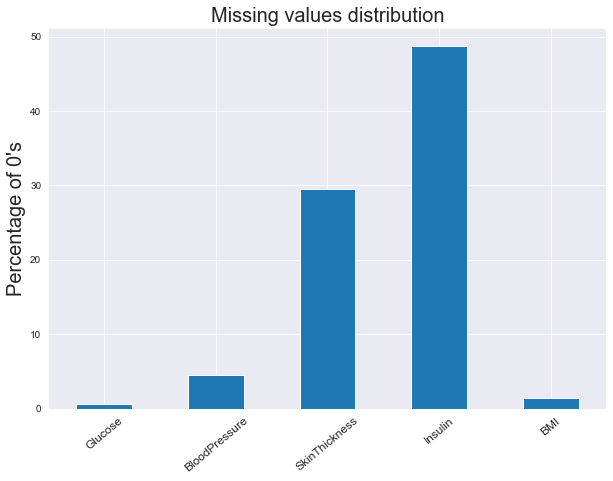

In [5]:
# features with 0's
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# set fig size
plt.rcParams["figure.figsize"] = (10,7)
sns.set_style('darkgrid')

#plot
plot = ((data[features] == 0).sum() / data.shape[0] * 100).plot.bar()
plot.set_title('Missing values distribution', fontsize=20)
plot.set_xticklabels(features, rotation=40, fontsize=12)
plot.set_ylabel("Percentage of 0's", fontsize=20)

# reset fig size to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Insulin: Almost 50% of values are 0 (missing)...is important factor for Diabetics.
### SkinThickness follows second with around 30%, others are in acceptable range
### Check on Distribution

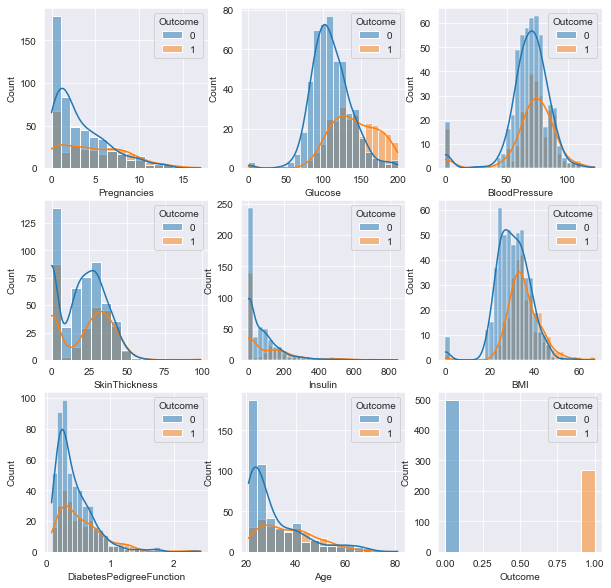

In [6]:
sns.set_style('darkgrid')
fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (10,10))

for i in range(0, len(data.columns)):
    rows = i // 3
    cols = i % 3
    ax = axs[rows,cols]
    plot = sns.histplot(x = data.columns[i], hue= data.Outcome, data=data, ax=ax, kde=True)

data.describe()

# reset fig size to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

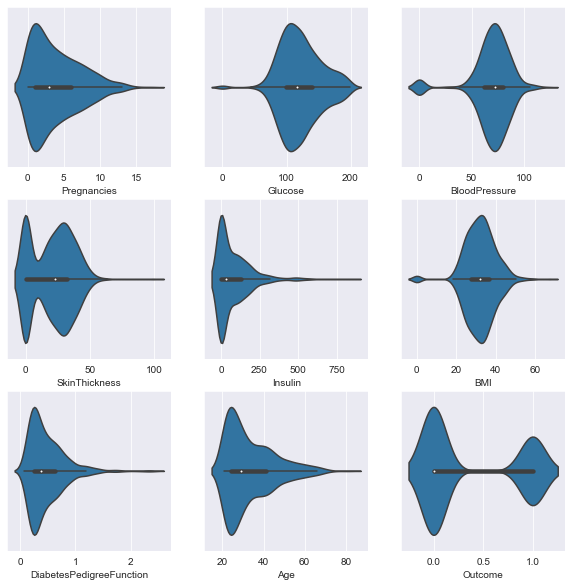

In [7]:
fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (10,10))

for i in range(0, len(data.columns)):
    rows = i // 3
    cols = i % 3
    ax = axs[rows,cols]
    plot = sns.violinplot(x = data.columns[i], data=data, ax=ax)


### Except (Glucose, BloodPressure and BMI with extreme Outliers), other features are severly skewed
### Since data is small, no Outlier treatment

### Check for Imbalance in data

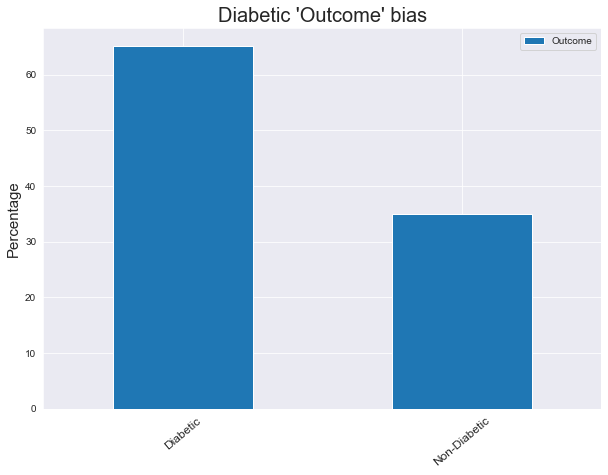

In [8]:
# set fig size
plt.rcParams["figure.figsize"] = (10,7)
sns.set_style('darkgrid')

plot = data.Outcome.value_counts(normalize=True).mul(100).plot.bar()
plot.set_xticklabels(['Diabetic', 'Non-Diabetic'], rotation=40, fontsize=12)
plot.set_title("Diabetic 'Outcome' bias", fontsize=20)
plot.set_ylabel("Percentage", fontsize=15)
plot.set_xlabel(str(), fontdict={'size': 20})
plot.legend()

# reset fig size to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Check correlation amongst features ->

<AxesSubplot:>

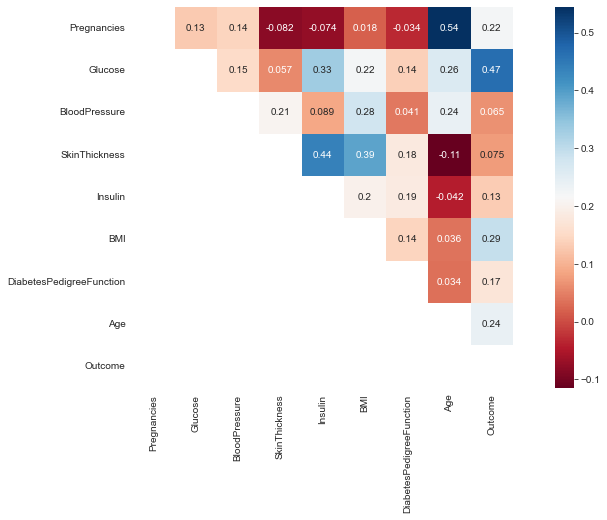

In [88]:
sns.heatmap(data[data.columns].corr(), annot = True, square=True,cmap="RdBu",mask=np.tril(data.corr()))

### Only Glucose has a somewhat decent correlation wit Outcome (label) others are not.
### Check on distribution using scatter plot

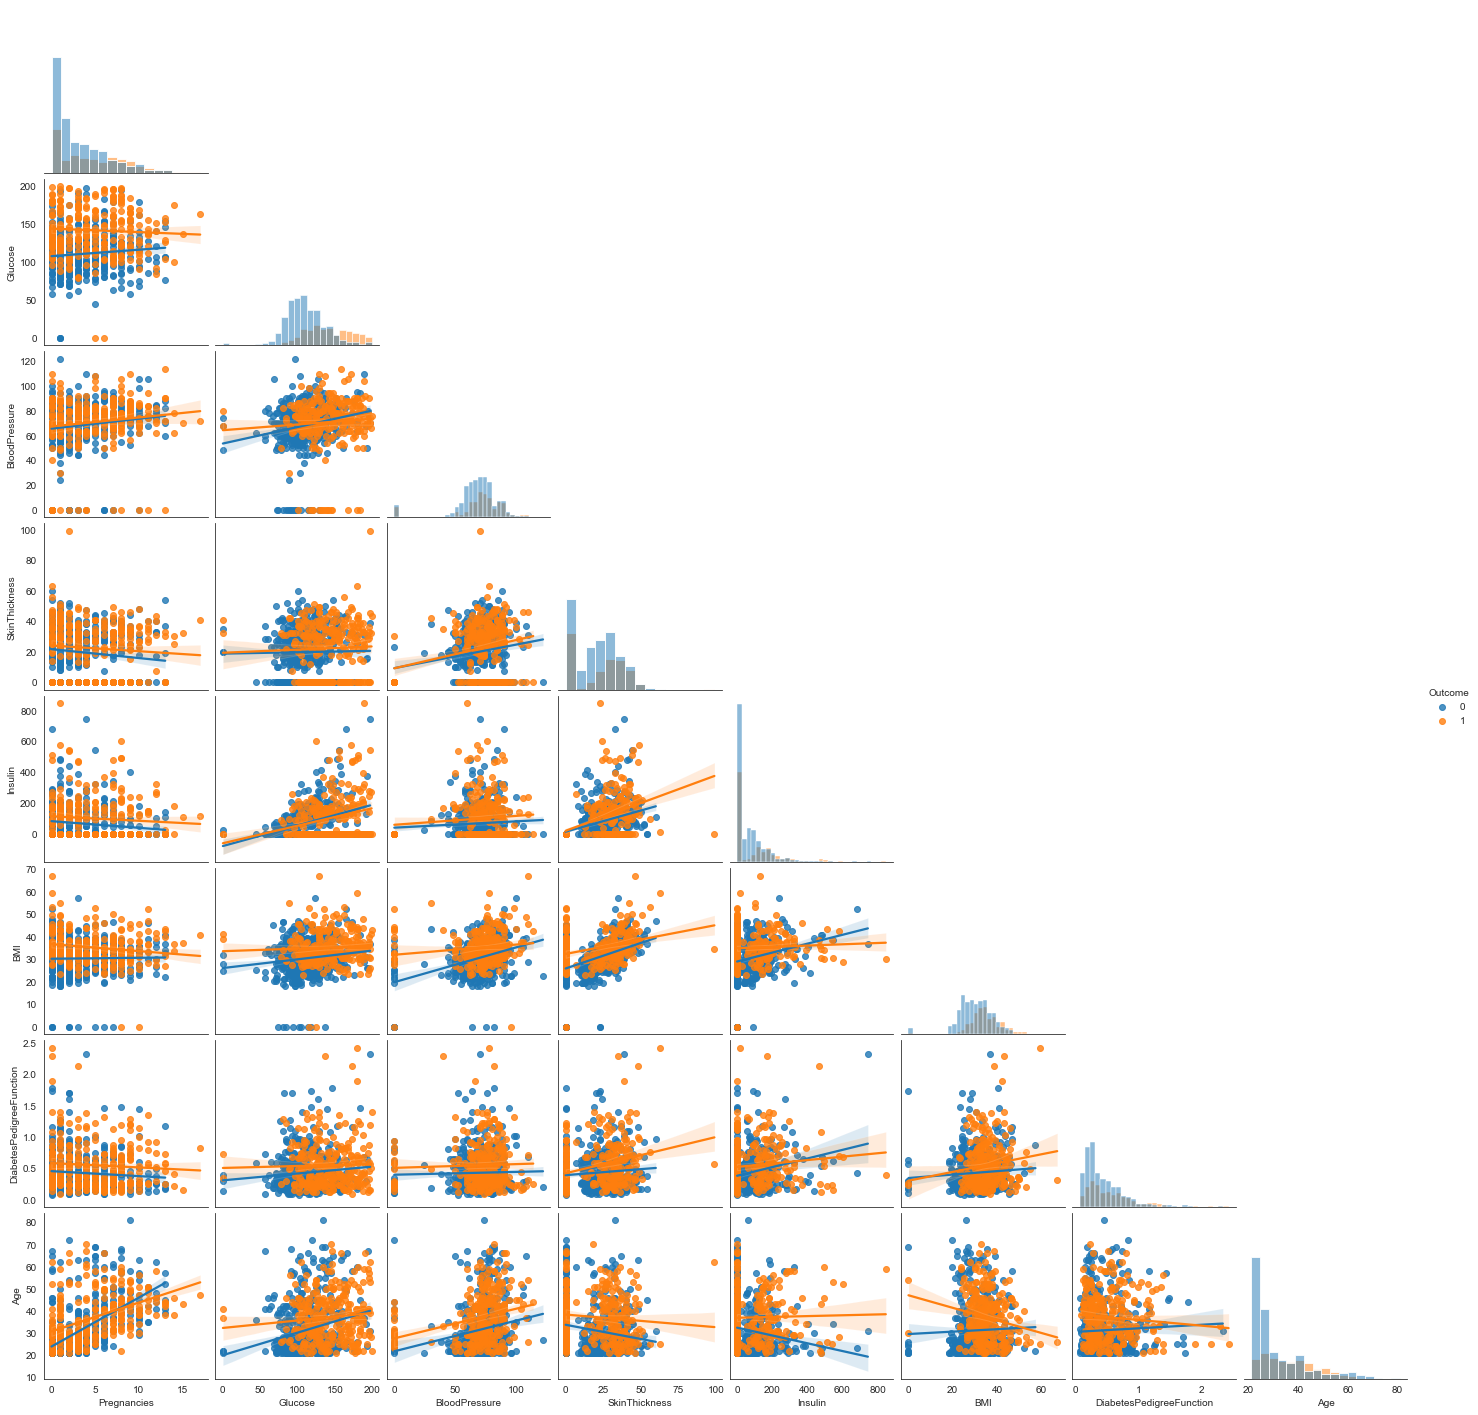

In [92]:
sns.pairplot(data=data, kind='reg', hue = 'Outcome', corner=True, diag_kind='hist')

### There are losts of overlap amongst diabetic and non-diabetic
### Check for multicolinearity

In [93]:
custom_feat_treatment.get_Multicolinearity(data, data.columns)

,feature,VIF
0,const,39.646259
1,Pregnancies,1.461247
2,Glucose,1.525018
3,BloodPressure,1.194716
4,SkinThickness,1.507471
5,Insulin,1.430267
6,BMI,1.366240
7,DiabetesPedigreeFunction,1.082105
8,Age,1.594364
9,Outcome,1.435241


### No Multiclinearity amongst features.
### Data is imbalanced, biased towards Diabetic patients (severe skew since Non-diabetic data < 50%)

### Model Building Approach
* >>> ### Avoid classifying a diabetic patient as Non-diabetic since over a period of time this could become danger to patients health
* >>> ### Patients falsely diagnosed with diabetes can undergo further clinical trial for certainty (prevention is better than cure(cost))
* >>> ### Build aggresive model focussed on reducing false negative with an acceptable range for false positives

### Threshold Metric for imbalanced classification (focus on prediction of labels):
* >>> ### FBeta scoring for beta = 2 focussed on false negatives (patients wrongly diagnosed as Non-Diabetic)

### Probabilistic metrics for imbalanced Classification (focus on probability of labels)
* >>> ### Brier Score (0 = best score) will be used since it focusses on Positive (minority class) to get final performance of our model

### Ranking metrics for imbalanced classification
* >>> ### ROC/ROC_AUC score (optimistic on both labels)  and PR/PR_AUC score will be used (focussed on minority label)



# Feature Engineering

### 1. Missing value treatment for features (replace 0 with NaN's)
###    On few columns, a value of zero does not make sense and thus indicates missing value:

In [9]:
# Replace 0's with nan
data_imputed = data.replace(0, value={'Glucose': np.nan, 'BloodPressure': np.nan, 'SkinThickness': np.nan, 'Insulin': np.nan, 'BMI': np.nan})

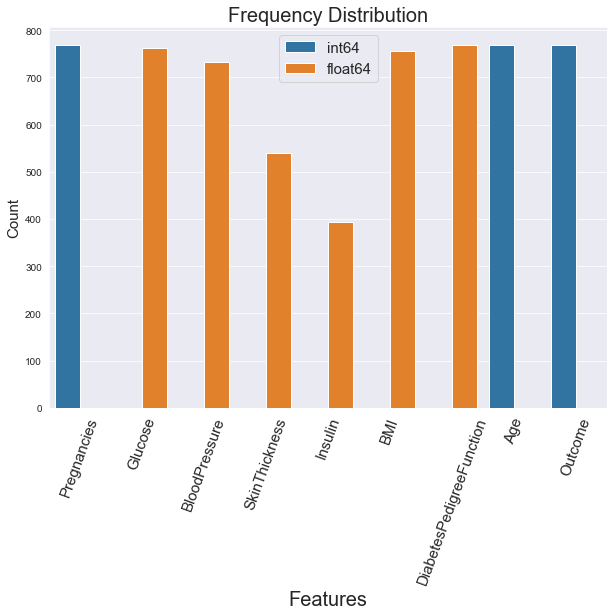

,features,types,null_counts
0,Pregnancies,int64,768
1,Glucose,float64,763
2,BloodPressure,float64,733
3,SkinThickness,float64,541
4,Insulin,float64,394
5,BMI,float64,757
6,DiabetesPedigreeFunction,float64,768
7,Age,int64,768
8,Outcome,int64,768


In [10]:
custom_feat_treatment.plot_Info(data_imputed)

* >>> ### Impute features with median values 
* >>> ### median(features == diabetic) and median (features == non-diabetic)

In [11]:
# seperate diabetic and non-diabetc data
data_non_diabetic = data_imputed[data_imputed.Outcome==0]
data_diabetic = data_imputed[data_imputed.Outcome==1]
print('data shapes: ', data_non_diabetic.shape, data_diabetic.shape)

# impute values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_non_diabetic = pd.DataFrame(imputer.fit_transform(data_non_diabetic), columns=data.columns)
data_diabetic = pd.DataFrame(imputer.fit_transform(data_diabetic), columns=data.columns)

# union data diabetic and non-diabetic 
data_imputed = pd.concat([data_non_diabetic, data_diabetic], axis=0, ignore_index=True)
data_imputed.isna().sum()


data shapes:  (500, 9) (268, 9)


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

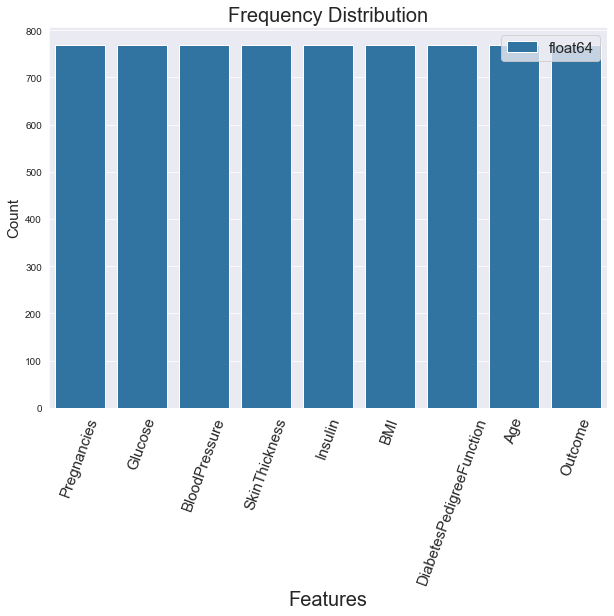

,features,types,null_counts
0,Pregnancies,float64,768
1,Glucose,float64,768
2,BloodPressure,float64,768
3,SkinThickness,float64,768
4,Insulin,float64,768
5,BMI,float64,768
6,DiabetesPedigreeFunction,float64,768
7,Age,float64,768
8,Outcome,float64,768


In [12]:
custom_feat_treatment.plot_Info(data_imputed)

### Export Data from Tableau with Correlation

In [13]:
data_imputed[data.columns].corr().unstack().to_frame().reset_index().to_excel('Correlation.xlsx')

### 2. Feature Extraction methods (derive new features from existing)

<AxesSubplot:xlabel='Glucose', ylabel='Age'>

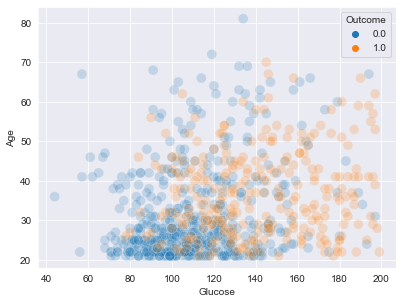

In [14]:
sns.scatterplot(data_imputed.Glucose, data_imputed.Age, hue=data_imputed.Outcome, s=100, alpha = 0.2,  x_jitter=True)

### Most non-diabetic females are concentrated when Glucose <= 120 and Age is [20, 30)
### We create f1 categorical feature with 0 and 1 => 0 = Glucose <= 120 and Age is [20, 30)

In [15]:
data_imputed['f1'] = 1
data_imputed.loc[data_imputed[(data_imputed.Glucose <= 120) & (data_imputed.Age <= 30)].index, 'f1'] = 0

<AxesSubplot:xlabel='Pregnancies', ylabel='Age'>

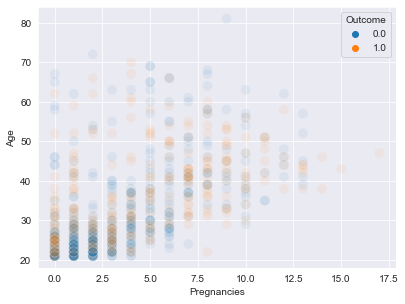

In [16]:
sns.scatterplot(data_imputed.Pregnancies, data_imputed.Age, hue=data_imputed.Outcome, s=100, alpha = 0.07, x_jitter=True)

### Most non-diabetic females are concentrated when Pregnancies <= 6 and Age is [20, 30)
### We create f2 categorical feature with 0 and 1 => 0 = Pregnancies <= 120 and Age is [20, 30)

In [17]:
data_imputed['f2'] = 1
data_imputed.loc[data_imputed[(data_imputed.Pregnancies <= 6) & (data_imputed.Age <= 30)].index, 'f2'] = 0

### If BMI is more than 30 then overweight(1) otherwise healthy(0)
### We create f3 categorical feature with 0 and 1 => 0 = BMI >= 30 

In [18]:
data_imputed['f3'] = 1
data_imputed.loc[data_imputed[data_imputed.BMI >= 30].index, 'f3'] = 0

<AxesSubplot:xlabel='Glucose', ylabel='BloodPressure'>

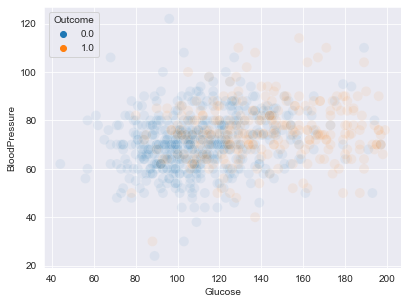

In [19]:
sns.scatterplot(data_imputed.Glucose, data_imputed.BloodPressure, hue=data_imputed.Outcome, s=100, alpha = 0.07, x_jitter=True)

### Most non-diabetic females are concentrated when Glucose <= 110 and BloodPressure <= 80
### We create f4 categorical feature with 0 and 1 => 0 = Glucose <= 110 and BloodPressure <= 80

In [20]:
data_imputed['f4'] = 1
data_imputed.loc[data_imputed[(data_imputed.Glucose <= 110) & (data_imputed.BloodPressure <= 80)].index, 'f4'] = 0

<AxesSubplot:xlabel='SkinThickness', ylabel='BMI'>

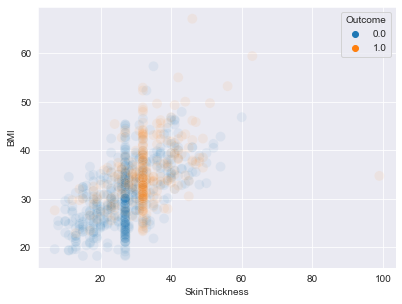

In [21]:
sns.scatterplot(data_imputed.SkinThickness, data_imputed.BMI, hue=data_imputed.Outcome, s=100, alpha = 0.07, x_jitter=True)

### Most non-diabetic females are concentrated when SkinThickness <= 25 and BMI <= 30
### We create f5 categorical feature with 0 and 1 => 0 = SkinThickness <= 25 and BMI <= 30

In [22]:
data_imputed['f5'] = 1
data_imputed.loc[data_imputed[(data_imputed.SkinThickness <= 25) & (data_imputed.BMI <= 30)].index, 'f5'] = 0

<AxesSubplot:xlabel='Glucose', ylabel='BMI'>

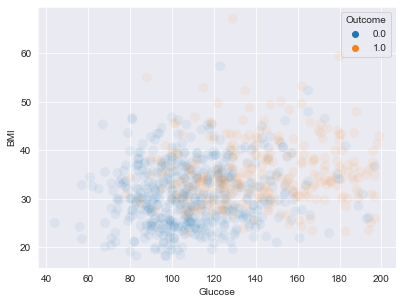

In [23]:
sns.scatterplot(data_imputed.Glucose, data_imputed.BMI, hue=data_imputed.Outcome, s=100, alpha = 0.07, x_jitter=True)

### Most non-diabetic females are concentrated when Glucose <= 105 and BMI <= 30
### We create f6 categorical feature with 0 and 1 => 0 = Glucose <= 105 and BMI <= 30

In [24]:
data_imputed['f6'] = 1
data_imputed.loc[data_imputed[(data_imputed.Glucose <= 105) & (data_imputed.BMI <= 30)].index, 'f6'] = 0


### Create other categorical features

In [25]:
data_imputed['f7'] = 0
data_imputed['f8'] = 0
data_imputed['f9'] = 0
data_imputed['f10'] = 0

data_imputed.loc[data_imputed[data_imputed.Insulin <=200].index, 'f7'] = 1
data_imputed.loc[data_imputed[data_imputed.BloodPressure <= 80].index, 'f8'] = 1
data_imputed.loc[data_imputed[(data_imputed.Pregnancies < 4) & (data_imputed.Pregnancies is not 0)].index, 'f9'] = 1
data_imputed.loc[data_imputed[data_imputed.BloodPressure <= 80].index, 'f10'] = 1

In [26]:
data_imputed['f11'] = data_imputed['BMI'] * data_imputed['SkinThickness']
data_imputed['f12'] = data_imputed['Pregnancies'] / data_imputed['Age']
data_imputed['f13'] = data_imputed['Glucose'] / data_imputed['DiabetesPedigreeFunction']
data_imputed['f14'] = data_imputed['Age'] * data_imputed['DiabetesPedigreeFunction']
data_imputed['f15'] = data_imputed['Age'] / data_imputed['Insulin']


In [27]:
print('No of nan entries after data imputed:' , data_imputed.isna().any().sum())
data_imputed

No of nan entries after data imputed: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,f1,...,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
0,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0,1,...,0,1,1,1,1,771.4,0.032258,242.165242,10.881,0.302439
1,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,0,...,0,1,1,1,1,646.3,0.047619,532.934132,3.507,0.223404
2,5.0,116.0,74.0,27.0,102.5,25.6,0.201,30.0,0.0,0,...,1,1,1,0,1,691.2,0.166667,577.114428,6.030,0.292683
3,10.0,115.0,70.0,27.0,102.5,35.3,0.134,29.0,0.0,0,...,1,1,1,0,1,953.1,0.344828,858.208955,3.886,0.282927
4,4.0,110.0,92.0,27.0,102.5,37.6,0.191,30.0,0.0,0,...,1,1,0,0,0,1015.2,0.133333,575.916230,5.730,0.292683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.0,128.0,88.0,39.0,110.0,36.5,1.057,37.0,1.0,1,...,1,1,0,1,0,1423.5,0.027027,121.097446,39.109,0.336364
764,0.0,123.0,72.0,32.0,169.5,36.3,0.258,52.0,1.0,1,...,1,1,1,1,1,1161.6,0.000000,476.744186,13.416,0.306785
765,6.0,190.0,92.0,32.0,169.5,35.5,0.278,66.0,1.0,1,...,1,1,0,0,0,1136.0,0.090909,683.453237,18.348,0.389381
766,9.0,170.0,74.0,31.0,169.5,44.0,0.403,43.0,1.0,1,...,1,1,1,0,1,1364.0,0.209302,421.836228,17.329,0.253687


### Extract original feature, engineering features and all features

In [28]:
features_engineered = data_imputed.columns.difference(data.columns).values
features_original = data.columns[:-1].values
features_all = list(features_engineered) + list(features_original)
print('Features engineered: \n', features_engineered)
print('Original features: \n', features_original)
print('All features: \n', features_all)

Features engineered: 
 ['f1' 'f10' 'f11' 'f12' 'f13' 'f14' 'f15' 'f2' 'f3' 'f4' 'f5' 'f6' 'f7'
 'f8' 'f9']
Original features: 
 ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']
All features: 
 ['f1', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


### Transformations to apply on data to get normal distribution
### Distribution without transformations

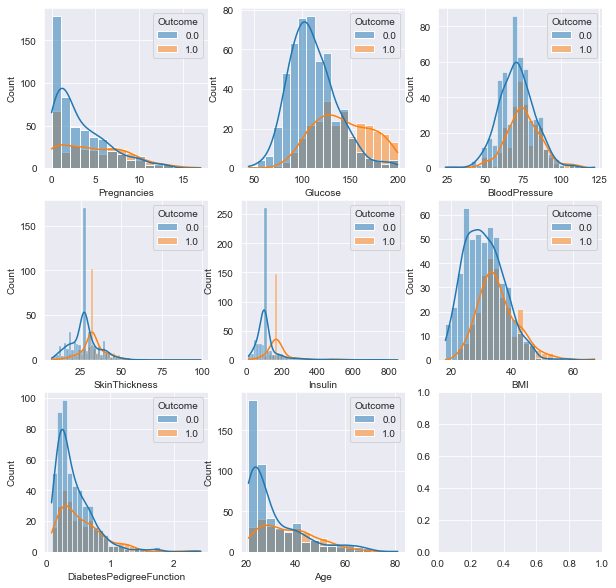

In [29]:
data_imputed = data_imputed.reset_index(drop=True)
sns.set_style('darkgrid')
fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (10,10))

for i in range(0, len(data_imputed[features_original].columns)):
    rows = i // 3
    cols = i % 3
    ax1 = axs[rows,cols]
    plot = sns.histplot(x = data_imputed.columns[i], hue= data_imputed.Outcome, data=data_imputed, ax=ax1, kde=True)

data.describe()

# reset fig size to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### We use Quantile transformations and RobustScalar for normal distribution transformation

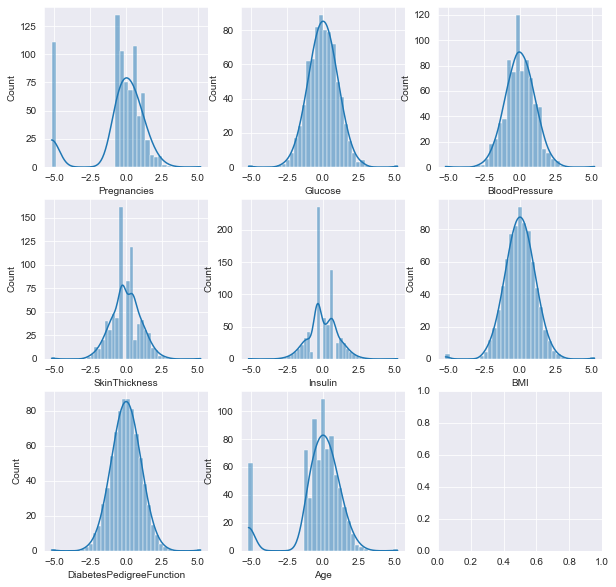

In [30]:
# Transformation
qt = QuantileTransformer(output_distribution='normal')
X_power_transformed_qt = pd.DataFrame(qt.fit_transform(data_imputed[features_original]), columns=features_original)

# plot
data_imputed = data_imputed.reset_index(drop=True)
sns.set_style('darkgrid')
fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (10,10))

for i in range(0, len(X_power_transformed_qt[features_original].columns)):
    rows = i // 3
    cols = i % 3
    ax1 = axs[rows,cols]
    plot = sns.histplot(x = X_power_transformed_qt.columns[i], data=X_power_transformed_qt, ax=ax1, kde=True)

data.describe()

# reset fig size to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Check Multicolinearity. No Multicolinearity amongst features

In [31]:
custom_feat_treatment.get_Multicolinearity(data_imputed[features_original], data_imputed[features_original].columns)

,feature,VIF
0,const,53.163830
1,Pregnancies,1.430251
2,Glucose,1.460334
3,BloodPressure,1.249917
4,SkinThickness,1.513720
5,Insulin,1.362770
6,BMI,1.637213
7,DiabetesPedigreeFunction,1.049660
8,Age,1.614236


### 3. Feature Combination methods (which combinations represent best combination)
* >>> ### 1. With engineered features

features:  ['f1' 'f10' 'f11' 'f12' 'f13' 'f14' 'f15' 'f2' 'f3' 'f4' 'f5' 'f6' 'f7'
 'f8' 'f9']


,imp_features
RandomForestClassifier(),"[f1, f11, f12, f13, f14, f15, f2, f3, f4, f5, ..."
GradientBoostingClassifier(),"[f1, f11, f13, f14, f15, f2, f4]"
AdaBoostClassifier(),"[f11, f13, f14, f15]"
DecisionTreeClassifier(),"[f1, f11, f12, f13, f14, f15, f2]"
ExtraTreeClassifier(),"[f1, f11, f12, f13, f14, f15, f2, f3, f4, f7, f9]"
LogisticRegression(),"[f1, f10, f12, f15, f2, f3, f4, f6, f7, f8]"


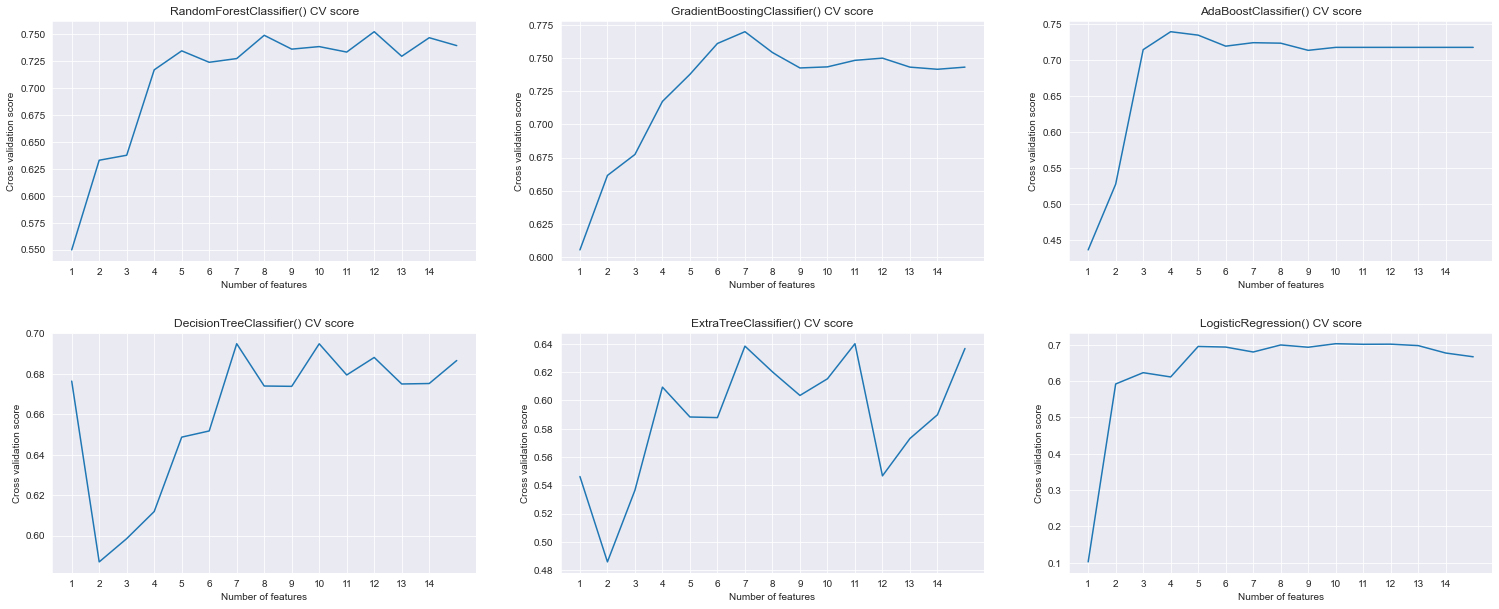

In [32]:
# prepare data
X = data_imputed[features_engineered]
y = data_imputed.Outcome.values
print('features: ', X.columns.values)

# get imp features
models = ['RandomForestClassifier()', 'GradientBoostingClassifier()', 'AdaBoostClassifier()', 'DecisionTreeClassifier()', 'ExtraTreeClassifier()', 'LogisticRegression()']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
df_results = custom_feat_treatment.get_imp_features(X=X_train, y=y_train, models=models, plot=True)
df_results

* >>> ### 2. Without Entineered features

features:  ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']


,imp_features
RandomForestClassifier(),"[Glucose, SkinThickness, Insulin, BMI, Diabete..."
GradientBoostingClassifier(),"[Glucose, SkinThickness, Insulin, BMI, Diabete..."
AdaBoostClassifier(),"[Glucose, Insulin, BMI, DiabetesPedigreeFuncti..."
DecisionTreeClassifier(),"[Glucose, Insulin, BMI, Age]"
ExtraTreeClassifier(),[Insulin]
LogisticRegression(),"[Pregnancies, Glucose, BloodPressure, SkinThic..."


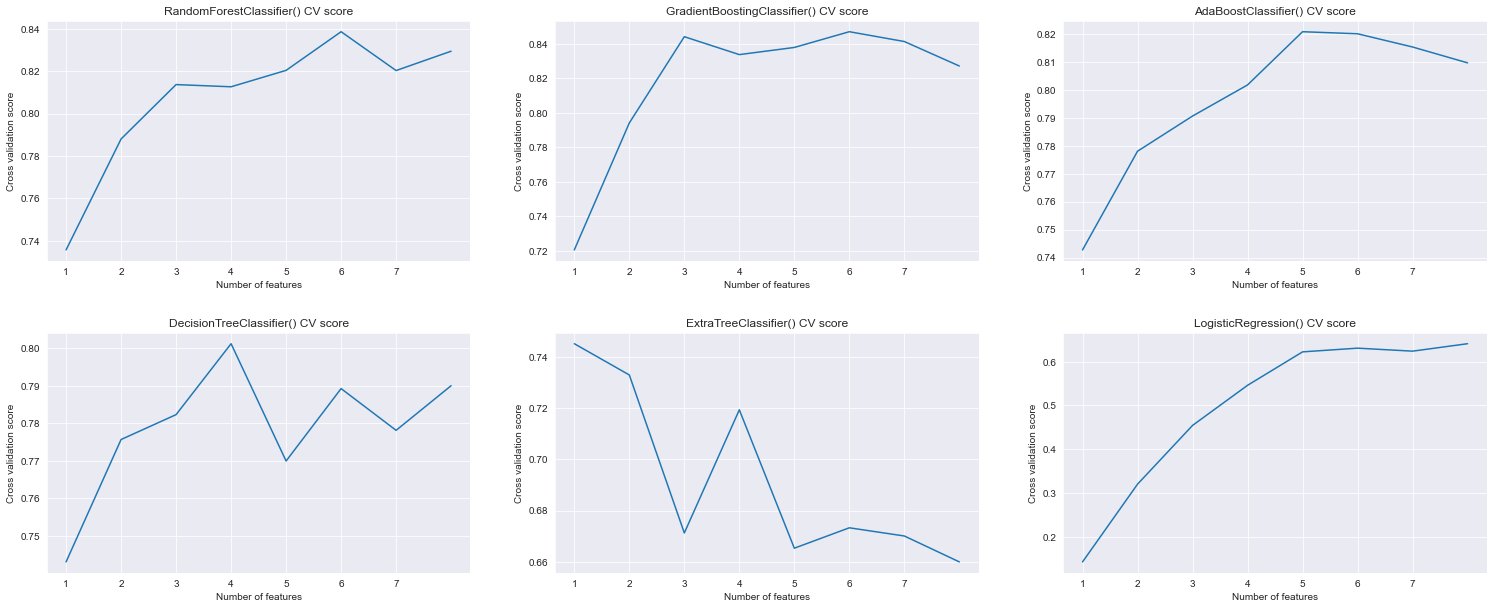

In [33]:
# prepare data
X = data_imputed[features_original]
y = data_imputed.Outcome.values
print('features: ', X.columns.values)

# get imp features
models = ['RandomForestClassifier()', 'GradientBoostingClassifier()', 'AdaBoostClassifier()', 'DecisionTreeClassifier()', 'ExtraTreeClassifier()', 'LogisticRegression()']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
df_results = custom_feat_treatment.get_imp_features(X=X_train, y=y_train, models=models, plot=True)
df_results

* >>> ### 3. All features

features:  ['f1' 'f10' 'f11' 'f12' 'f13' 'f14' 'f15' 'f2' 'f3' 'f4' 'f5' 'f6' 'f7'
 'f8' 'f9' 'Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness'
 'Insulin' 'BMI' 'DiabetesPedigreeFunction' 'Age']


,imp_features
RandomForestClassifier(),"[f11, f15, Glucose, SkinThickness, Insulin, Age]"
GradientBoostingClassifier(),"[Glucose, Insulin, Age]"
AdaBoostClassifier(),"[f11, f14, f15, Glucose, Insulin, BMI, Diabete..."
DecisionTreeClassifier(),"[f10, f11, f12, f13, f14, f15, f2, f3, f4, f5,..."
ExtraTreeClassifier(),"[Glucose, SkinThickness, Insulin, BMI]"
LogisticRegression(),"[f1, f15, f2, f3, f4, f6, f8]"


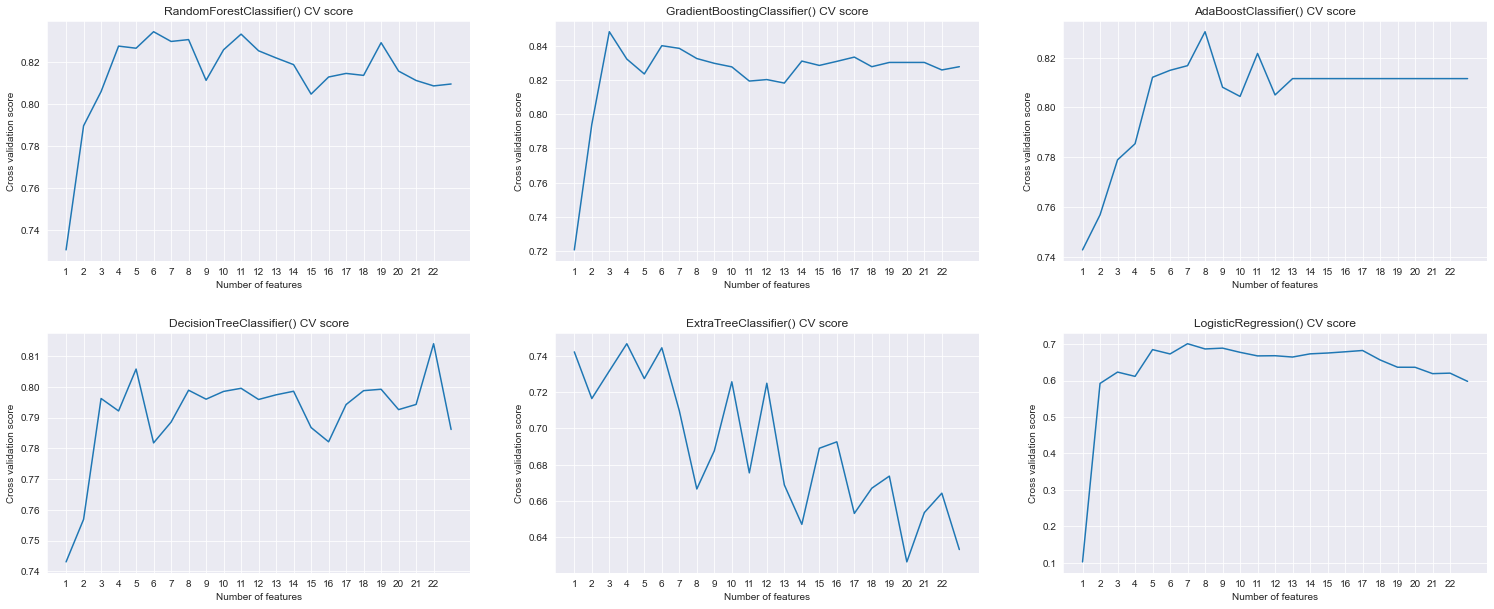

In [34]:
# prepare data
X = data_imputed[features_all]
y = data_imputed.Outcome.values
print('features: ', X.columns.values)

# get imp features
models = ['RandomForestClassifier()', 'GradientBoostingClassifier()', 'AdaBoostClassifier()', 'DecisionTreeClassifier()', 'ExtraTreeClassifier()', 'LogisticRegression()']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
df_results = custom_feat_treatment.get_imp_features(X=X_train, y=y_train, models=models, plot=True)
df_results

### In all 3 cases of Feature combinations above, with most of classifiers, the score increases with the number of features
### Model Evaluation using SMOTE (imbalanced)
### Evaluate classifiers on all features using ROc_AUC and PR_AUC scores
### Once we finalize on Model we will try to find optimum number of features

In [35]:
X = data_imputed[features_all]
y = data_imputed.Outcome

In [36]:
models = []
models.append((KNeighborsClassifier(n_jobs=-1)))
models.append(SVC(probability=True))
models.append(LogisticRegression(n_jobs=-1))
models.append(DecisionTreeClassifier())
models.append(GaussianNB())
models.append(RandomForestClassifier(n_jobs=-1))
models.append(GradientBoostingClassifier())
models.append(XGBClassifier(verbosity=0))
models.append(LGBMClassifier(n_jobs=-1))

steps_models = []
steps_models.append(('NoSMOTE', ([('std', std), ('tr', tf)])))
steps_models.append(('SMOTE', [('over', SMOTE()), ('std', std), ('tr', tf)]))
steps_models.append(('BorderlineSMOTE' , [('over', BorderlineSMOTE()), ('std', std), ('tr', tf)]))
steps_models.append(('ADASYN', [('over', ADASYN()), ('std', std), ('tr', tf)]))
steps_models.append(('NearMiss_1', [('over', NearMiss(version=1)), ('std', std), ('tr', tf)]))
steps_models.append(('NearMiss_2', [('over', NearMiss(version=2)), ('std', std), ('tr', tf)]))
steps_models.append(('NearMiss_3', [('over', NearMiss(version=3)), ('std', std), ('tr', tf)]))
steps_models.append(('ENN', [('over', EditedNearestNeighbours(n_neighbors=5, n_jobs=-1)), ('std', std), ('tr', tf)]))
steps_models.append(('OneSidedSelection', [('over', OneSidedSelection(n_neighbors=5, n_jobs=-1, n_seeds_S=10)), ('std', std), ('tr', tf)]))
steps_models.append(('NeighbourhoodCleaningRule', [('over', NeighbourhoodCleaningRule(n_neighbors=5, n_jobs=-1, threshold_cleaning=0.5)), ('std', std), ('tr', tf)]))
steps_models.append(('RandomOverSampler_RandomUnderSampler', [('o', RandomOverSampler(sampling_strategy='auto')), ('u', RandomUnderSampler(sampling_strategy='auto')), ('std', std), ('tr', tf)]))
steps_models.append(('SMOTE_RandomUnderSampler', [('o', SMOTE(sampling_strategy='auto')), ('u', RandomUnderSampler(sampling_strategy='auto')), ('std', std), ('tr', tf)]))
steps_models.append(('SMOTETomek_SMOTETomek', [('ou', SMOTETomek(smote = SMOTE(), tomek=TomekLinks(), n_jobs=-1)), ('std', std), ('tr', tf)]))
steps_models.append(('SMOTEENN', [('ou', SMOTEENN(n_jobs=-1)), ('std', std), ('tr', tf)]))
steps_models.append(('SMOTEEN_ENN', [('ou', SMOTEENN(smote = SMOTE(), enn = EditedNearestNeighbours(sampling_strategy='auto'), n_jobs=-1)), ('std', std), ('tr', tf)]))

steps_models_dict = {item[0]: item[1] for item in steps_models}
models_dict = {item.__class__.__name__ : item for item in models}


### RepeatedStratifiedKFold, Quantile Transformation, RobustScalar, SMOTE configurations, Cross_val_score

In [37]:
basic_modelling = Imbalanced_CLassifiers(list_of_classifiers=models, metric_to_test='roc-auc', X=X, y=y)
basic_modelling.conf_data_train_Test(test_size=0.2, random_state=12)

### ROC_AUC comparisones for classifiers

In [38]:
print("Mean score (RepeatedStratifiedKFold(3) ROC_AUC Scores of classifiers:")
print("")
df_results_roc_auc, df_roc_auc_top = basic_modelling.evaluate_models_with_steps(lst_classifiers=None, list_of_steps=steps_models, metric='roc_auc', ret_df=True, ret_top_val=True)
df_results_roc_auc

Mean score (RepeatedStratifiedKFold(3) ROC_AUC Scores of classifiers:



,NoSMOTE,SMOTE,BorderlineSMOTE,ADASYN,NearMiss_1,NearMiss_2,NearMiss_3,ENN,OneSidedSelection,NeighbourhoodCleaningRule,RandomOverSampler_RandomUnderSampler,SMOTE_RandomUnderSampler,SMOTETomek_SMOTETomek,SMOTEENN,SMOTEEN_ENN
KNeighborsClassifier,0.839348,0.840057,0.833525,0.839606,0.838247,0.783311,0.825452,0.837648,0.839530,0.817576,0.839054,0.841215,0.836134,0.830019,0.817143
SVC,0.862390,0.871111,0.870202,0.868200,0.859345,0.805073,0.862101,0.856555,0.867985,0.854089,0.867382,0.869931,0.869958,0.853502,0.852605
LogisticRegression,0.898236,0.885239,0.885191,0.882298,0.886229,0.734291,0.892603,0.878040,0.897144,0.884903,0.893825,0.885732,0.886516,0.882773,0.886892
DecisionTreeClassifier,0.836221,0.816597,0.823761,0.827303,0.786496,0.690213,0.808138,0.794594,0.822570,0.810952,0.819492,0.819077,0.831397,0.829887,0.819708
GaussianNB,0.835743,0.832596,0.834451,0.835889,0.826262,0.623604,0.843073,0.818398,0.835759,0.823214,0.835499,0.831142,0.830173,0.816966,0.826129
RandomForestClassifier,0.938586,0.937356,0.936836,0.935417,0.927491,0.878667,0.936740,0.913968,0.936460,0.911779,0.939467,0.933353,0.936863,0.914544,0.931861
GradientBoostingClassifier,0.950251,0.949564,0.949670,0.948921,0.923335,0.855929,0.944461,0.922139,0.950115,0.910217,0.951417,0.950502,0.947605,0.916394,0.937358
XGBClassifier,0.947821,0.944368,0.941941,0.947728,0.934534,0.897818,0.939580,0.920145,0.942781,0.913368,0.942392,0.944876,0.946204,0.920570,0.935270
LGBMClassifier,0.947447,0.949233,0.948085,0.947064,0.937907,0.883152,0.941109,0.917355,0.944104,0.915489,0.946933,0.945929,0.948516,0.920114,0.939560


### PR_AUC comparisons for classifiers

In [39]:
print("Mean score (RepeatedStratifiedKFold(3) PR_AUC Scores of classifiers:")
print("")
df_results_PR_AUC, df_PR_AUC_top = basic_modelling.evaluate_models_with_steps(lst_classifiers=None, list_of_steps=steps_models, metric=custom_metrics.precision_recall_score, ret_df=True, ret_top_val=True)
df_results_PR_AUC

Mean score (RepeatedStratifiedKFold(3) PR_AUC Scores of classifiers:



,NoSMOTE,SMOTE,BorderlineSMOTE,ADASYN,NearMiss_1,NearMiss_2,NearMiss_3,ENN,OneSidedSelection,NeighbourhoodCleaningRule,RandomOverSampler_RandomUnderSampler,SMOTE_RandomUnderSampler,SMOTETomek_SMOTETomek,SMOTEENN,SMOTEEN_ENN
KNeighborsClassifier,0.738846,0.749048,0.746793,0.741382,0.731806,0.672855,0.730049,0.755152,0.734867,0.738349,0.747500,0.747507,0.752272,0.738105,0.736640
SVC,0.773680,0.777879,0.774609,0.782078,0.758290,0.700688,0.782323,0.751497,0.779736,0.756594,0.777679,0.781792,0.770659,0.735343,0.762187
LogisticRegression,0.809628,0.791883,0.793774,0.795990,0.794248,0.518489,0.801200,0.744121,0.810682,0.773040,0.812614,0.790586,0.796572,0.752855,0.793154
DecisionTreeClassifier,0.822117,0.804660,0.805345,0.799084,0.766932,0.699597,0.792722,0.772523,0.813342,0.779080,0.802163,0.791609,0.806363,0.803276,0.820083
GaussianNB,0.711721,0.703768,0.711200,0.706230,0.659122,0.414038,0.727838,0.656349,0.698555,0.659013,0.699985,0.700652,0.705406,0.675904,0.708850
RandomForestClassifier,0.903602,0.894960,0.892730,0.896263,0.877320,0.836798,0.896842,0.820975,0.893922,0.834704,0.893166,0.893016,0.893003,0.836473,0.891805
GradientBoostingClassifier,0.918787,0.917300,0.916219,0.915590,0.868685,0.787571,0.903192,0.828641,0.913987,0.834265,0.924237,0.915164,0.913082,0.842696,0.913619
XGBClassifier,0.915498,0.906089,0.915620,0.909161,0.900256,0.858817,0.904722,0.847691,0.911451,0.839254,0.913981,0.912497,0.911271,0.866537,0.908408
LGBMClassifier,0.917852,0.915397,0.910618,0.909476,0.887396,0.840726,0.911723,0.850710,0.910382,0.835079,0.917891,0.915740,0.909005,0.856380,0.903474


### F2 Score comparisons for classifiers

In [40]:
print("Mean score (RepeatedStratifiedKFold(3) F2 Scores of classifiers:")
print("")
df_results_f2_score, df_f2_score_top = basic_modelling.evaluate_models_with_steps(lst_classifiers=None, list_of_steps=steps_models, metric=custom_metrics.f2_score, ret_df=True, ret_top_val=True)
df_results_f2_score

Mean score (RepeatedStratifiedKFold(3) F2 Scores of classifiers:



,NoSMOTE,SMOTE,BorderlineSMOTE,ADASYN,NearMiss_1,NearMiss_2,NearMiss_3,ENN,OneSidedSelection,NeighbourhoodCleaningRule,RandomOverSampler_RandomUnderSampler,SMOTE_RandomUnderSampler,SMOTETomek_SMOTETomek,SMOTEENN,SMOTEEN_ENN
KNeighborsClassifier,0.670796,0.740215,0.740258,0.739003,0.756099,0.697647,0.726577,0.792006,0.711926,0.795967,0.754708,0.736673,0.725928,0.754973,0.672651
SVC,0.654350,0.740470,0.760252,0.746535,0.741518,0.696410,0.714706,0.766287,0.673053,0.764775,0.754824,0.744745,0.744227,0.724503,0.663054
LogisticRegression,0.749686,0.782510,0.795680,0.791458,0.804817,0.748361,0.790158,0.849738,0.785624,0.845876,0.820071,0.788086,0.778659,0.815904,0.749922
DecisionTreeClassifier,0.767801,0.790264,0.774405,0.766961,0.801197,0.752270,0.785147,0.829602,0.780876,0.821320,0.735083,0.789820,0.766307,0.804147,0.735101
GaussianNB,0.761490,0.764443,0.775007,0.773505,0.750779,0.104663,0.751556,0.792490,0.765000,0.784468,0.762964,0.761203,0.760415,0.761203,0.722667
RandomForestClassifier,0.809750,0.839854,0.836671,0.847226,0.839463,0.783842,0.828284,0.866913,0.830631,0.868306,0.820567,0.827342,0.830324,0.844079,0.761599
GradientBoostingClassifier,0.813967,0.829069,0.849803,0.844827,0.836246,0.751466,0.827279,0.864158,0.838063,0.867361,0.838617,0.832239,0.834194,0.832452,0.799961
XGBClassifier,0.812535,0.834609,0.837316,0.848050,0.839845,0.801699,0.836679,0.859508,0.835058,0.870075,0.828688,0.828205,0.820764,0.836507,0.780553
LGBMClassifier,0.819788,0.844447,0.842070,0.837815,0.847938,0.788388,0.828989,0.865297,0.836767,0.867432,0.827871,0.828403,0.825395,0.843458,0.784256


### Top scores for all 3 metrics

In [41]:
df_f2_score_top

,Imbalance,score
XGBClassifier,NeighbourhoodCleaningRule,0.870075
RandomForestClassifier,NeighbourhoodCleaningRule,0.868306
LGBMClassifier,NeighbourhoodCleaningRule,0.867432
GradientBoostingClassifier,NeighbourhoodCleaningRule,0.867361
LogisticRegression,ENN,0.849738
DecisionTreeClassifier,ENN,0.829602
KNeighborsClassifier,NeighbourhoodCleaningRule,0.795967
GaussianNB,ENN,0.792490
SVC,ENN,0.766287


In [42]:
df_PR_AUC_top

,Imbalance,score
GradientBoostingClassifier,RandomOverSampler_RandomUnderSampler,0.924237
LGBMClassifier,RandomOverSampler_RandomUnderSampler,0.917891
XGBClassifier,BorderlineSMOTE,0.915620
RandomForestClassifier,NoSMOTE,0.903602
DecisionTreeClassifier,NoSMOTE,0.822117
LogisticRegression,RandomOverSampler_RandomUnderSampler,0.812614
SVC,NearMiss_3,0.782323
KNeighborsClassifier,ENN,0.755152
GaussianNB,NearMiss_3,0.727838


In [43]:
df_roc_auc_top

,Imbalance,score
GradientBoostingClassifier,RandomOverSampler_RandomUnderSampler,0.951417
LGBMClassifier,SMOTE,0.949233
XGBClassifier,NoSMOTE,0.947821
RandomForestClassifier,RandomOverSampler_RandomUnderSampler,0.939467
LogisticRegression,NoSMOTE,0.898236
SVC,SMOTE,0.871111
GaussianNB,NearMiss_3,0.843073
KNeighborsClassifier,SMOTE_RandomUnderSampler,0.841215
DecisionTreeClassifier,NoSMOTE,0.836221


### Consolidated view to choose amongst the top classifiers

In [44]:
df_top_consolideted_results = df_f2_score_top.join(df_PR_AUC_top, how='left', lsuffix='_f2', rsuffix='_pr_auc').join(df_roc_auc_top, how='left', lsuffix='', rsuffix='_roc_auc')#.style.background_gradient(cmap = 'PuBu', subset = [ 'score_f2', 'score_pr_auc', 'score'])
df_top_consolideted_results_display = df_top_consolideted_results.style.background_gradient(cmap = 'PuBu', subset = [ 'score_f2', 'score_pr_auc', 'score'])
df_top_consolideted_results_display

,Imbalance_f2,score_f2,Imbalance_pr_auc,score_pr_auc,Imbalance,score
XGBClassifier,NeighbourhoodCleaningRule,0.870075,BorderlineSMOTE,0.915620,NoSMOTE,0.947821
RandomForestClassifier,NeighbourhoodCleaningRule,0.868306,NoSMOTE,0.903602,RandomOverSampler_RandomUnderSampler,0.939467
LGBMClassifier,NeighbourhoodCleaningRule,0.867432,RandomOverSampler_RandomUnderSampler,0.917891,SMOTE,0.949233
GradientBoostingClassifier,NeighbourhoodCleaningRule,0.867361,RandomOverSampler_RandomUnderSampler,0.924237,RandomOverSampler_RandomUnderSampler,0.951417
LogisticRegression,ENN,0.849738,RandomOverSampler_RandomUnderSampler,0.812614,NoSMOTE,0.898236
DecisionTreeClassifier,ENN,0.829602,NoSMOTE,0.822117,NoSMOTE,0.836221
KNeighborsClassifier,NeighbourhoodCleaningRule,0.795967,ENN,0.755152,SMOTE_RandomUnderSampler,0.841215
GaussianNB,ENN,0.792490,NearMiss_3,0.727838,NearMiss_3,0.843073
SVC,ENN,0.766287,NearMiss_3,0.782323,SMOTE,0.871111


### Top 4 classifiers show promising results. Subject to Voting classifier modelling
### We will evaluate Voting classifier model with all voting classifiers in top 4
### Feature selection using voting classifier and corresponding Imbalance technique with final scoring as f2-score

* > ### 1. Voting classifier using top 4 classifers with Imbalance techniqus from 'Imbalance_f2' column ->

In [45]:
df_top_consolideted_results.reset_index().loc[0:4, ['index', 'Imbalance_f2']]

,index,Imbalance_f2
0,XGBClassifier,NeighbourhoodCleaningRule
1,RandomForestClassifier,NeighbourhoodCleaningRule
2,LGBMClassifier,NeighbourhoodCleaningRule
3,GradientBoostingClassifier,NeighbourhoodCleaningRule
4,LogisticRegression,ENN


### Model Evaluation using best train test set

Top score with top selected features
F2-SCORE: 0.9246575342465753
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88        50
         1.0       0.71      1.00      0.83        27

    accuracy                           0.86        77
   macro avg       0.86      0.89      0.85        77
weighted avg       0.90      0.86      0.86        77



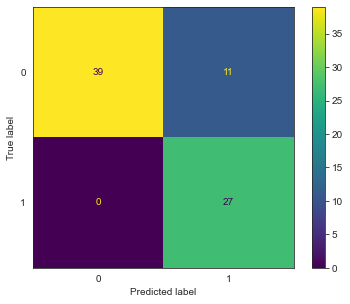

In [46]:
results = list()

# create pipeline
k = len(features_all)
fs = SelectKBest(score_func=f_classif, k=k)

step_RF = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['RandomForestClassifier'])]
step_gb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['GradientBoostingClassifier'])]
step_lgbm = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['LGBMClassifier'])]
step_xgb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['XGBClassifier'])]

pipe_RF = Pipeline_Imb(step_RF)
pipe_GB = Pipeline_Imb(step_gb)
pipe_LGB = Pipeline_Imb(step_lgbm)
pipe_XGB = Pipeline_Imb(step_xgb)

model = VotingClassifier(estimators=[
                                                ('rf', pipe_RF),
                                                ('lgbm', pipe_LGB),
                                                ('gb', pipe_GB),
                                                ('xgb', pipe_XGB)
                                                ],
                                                voting='soft'
                                                )

# evaluate the model
score_max = 0
X_train, X_test, y_train, y_test = None, None, None, None
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
for train_idx, test_idx in cv.split(X, y):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    yhat = model.predict(X.iloc[test_idx])

    score = fbeta_score(y.iloc[test_idx], yhat, beta=2)
    if score_max <= score:
        score_max = score
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        #print(score)

# model evaluation
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

sns.set_style('white')
print("Top score with top selected features")
print('F2-SCORE:', fbeta_score(y_true=y_test, y_pred=y_hat, beta=2))
print(classification_report(y_test, y_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()

### Evaluate model with random selection

F2-SCORE: 0.8904109589041095
              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83       101
         1.0       0.65      0.98      0.78        53

    accuracy                           0.81       154
   macro avg       0.82      0.85      0.81       154
weighted avg       0.87      0.81      0.82       154



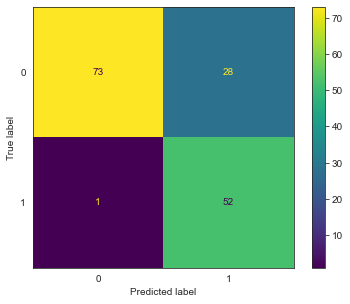

In [47]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=12)

# train test split
model.fit(X_train1, y_train1)
y_hat1 = model.predict(X_test1)

sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test1, y_pred=y_hat1, beta=2))
print(classification_report(y_test1, y_hat1))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, y_hat1)).plot()

* > ### 2. Voting classifier using top 4 classifers with Imbalance techniqus from 'Imbalance_pr_auc' column ->

In [48]:
df_top_consolideted_results.reset_index().loc[0:3, ['index', 'Imbalance_pr_auc']]

,index,Imbalance_pr_auc
0,XGBClassifier,BorderlineSMOTE
1,RandomForestClassifier,NoSMOTE
2,LGBMClassifier,RandomOverSampler_RandomUnderSampler
3,GradientBoostingClassifier,RandomOverSampler_RandomUnderSampler


### Model Evaluation using best train test set

F2-SCORE: 0.9712230215827337
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        50
         1.0       0.87      1.00      0.93        27

    accuracy                           0.95        77
   macro avg       0.94      0.96      0.94        77
weighted avg       0.95      0.95      0.95        77



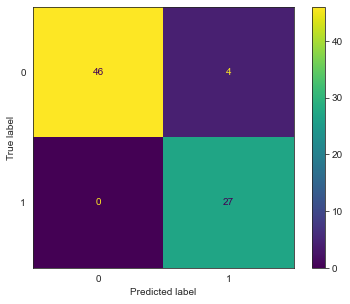

In [49]:
results = list()

# create pipeline
k = len(features_all)
fs = SelectKBest(score_func=f_classif, k=k)

step_RF = steps_models_dict['NoSMOTE'] + [('fs' ,fs)] + [('model', models_dict['RandomForestClassifier'])]
step_xgb = steps_models_dict['SMOTE_RandomUnderSampler'] + [('fs' ,fs)] + [('model', models_dict['XGBClassifier'])]
step_gb = steps_models_dict['NoSMOTE'] + [('fs' ,fs)] + [('model', models_dict['GradientBoostingClassifier'])]
step_lgbm = steps_models_dict['RandomOverSampler_RandomUnderSampler'] + [('fs' ,fs)] + [('model', models_dict['LGBMClassifier'])]


pipe_RF = Pipeline_Imb(step_RF)
pipe_GB = Pipeline_Imb(step_gb)
pipe_LGB = Pipeline_Imb(step_lgbm)
pipe_XGB = Pipeline_Imb(step_xgb)

model = VotingClassifier(estimators=[
                                                ('rf', pipe_RF),
                                                ('lgbm', pipe_LGB),
                                                ('gb', pipe_GB),
                                                ('xgb', pipe_XGB)
                                                ],
                                                voting='soft'
                                                )

# evaluate the model
score_max = 0
X_train, X_test, y_train, y_test = None, None, None, None
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
for train_idx, test_idx in cv.split(X, y):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    yhat = model.predict(X.iloc[test_idx])

    score = fbeta_score(y.iloc[test_idx], yhat, beta=2)
    if score_max <= score:
        score_max = score
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        #print(score)

# model evaluation
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test, y_pred=y_hat, beta=2))
print(classification_report(y_test, y_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()

### Evaluate model with random selection

F2-SCORE: 0.8876811594202899
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90       101
         1.0       0.77      0.92      0.84        53

    accuracy                           0.88       154
   macro avg       0.86      0.89      0.87       154
weighted avg       0.89      0.88      0.88       154



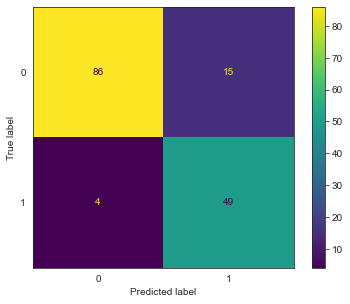

In [50]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=12)

# train test split
model.fit(X_train1, y_train1)
y_hat1 = model.predict(X_test1)

sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test1, y_pred=y_hat1, beta=2))
print(classification_report(y_test1, y_hat1))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, y_hat1)).plot()

* > ### 3. Voting classifier using top 4 classifers with Imbalance techniqus from 'Imbalance' column ->

In [51]:
df_top_consolideted_results.reset_index().loc[0:3, ['index', 'Imbalance']]

,index,Imbalance
0,XGBClassifier,NoSMOTE
1,RandomForestClassifier,RandomOverSampler_RandomUnderSampler
2,LGBMClassifier,SMOTE
3,GradientBoostingClassifier,RandomOverSampler_RandomUnderSampler


### Model Evaluation using best train test set

F2-SCORE: 0.9420289855072466
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95        50
         1.0       0.87      0.96      0.91        27

    accuracy                           0.94        77
   macro avg       0.92      0.94      0.93        77
weighted avg       0.94      0.94      0.94        77



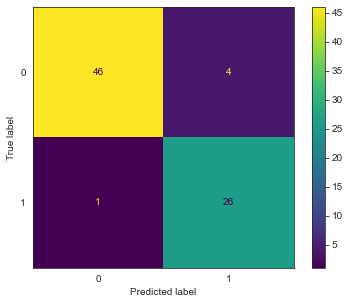

In [52]:
results = list()

# create pipeline
k = len(features_all)
fs = SelectKBest(score_func=f_classif, k=k)

step_RF = steps_models_dict['NoSMOTE'] + [('fs' ,fs)] + [('model', models_dict['RandomForestClassifier'])]
step_xgb = steps_models_dict['OneSidedSelection'] + [('fs' ,fs)] + [('model', models_dict['XGBClassifier'])]
step_gb = steps_models_dict['SMOTE_RandomUnderSampler'] + [('fs' ,fs)] + [('model', models_dict['GradientBoostingClassifier'])]
step_lgbm = steps_models_dict['SMOTETomek_SMOTETomek'] + [('fs' ,fs)] + [('model', models_dict['LGBMClassifier'])]


pipe_RF = Pipeline_Imb(step_RF)
pipe_GB = Pipeline_Imb(step_gb)
pipe_LGB = Pipeline_Imb(step_lgbm)
pipe_XGB = Pipeline_Imb(step_xgb)

model = VotingClassifier(estimators=[
                                                ('rf', pipe_RF),
                                                ('lgbm', pipe_LGB),
                                                ('gb', pipe_GB),
                                                ('xgb', pipe_XGB)
                                                ],
                                                voting='soft'
                                                )

# evaluate the model
score_max = 0
X_train, X_test, y_train, y_test = None, None, None, None
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
for train_idx, test_idx in cv.split(X, y):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    yhat = model.predict(X.iloc[test_idx])

    score = fbeta_score(y.iloc[test_idx], yhat, beta=2)
    if score_max <= score:
        score_max = score
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        #print(score)

# model evaluation
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test, y_pred=y_hat, beta=2))
print(classification_report(y_test, y_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()

### Evaluate model with random selection

F2-SCORE: 0.8812949640287769
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       101
         1.0       0.74      0.92      0.82        53

    accuracy                           0.86       154
   macro avg       0.85      0.88      0.86       154
weighted avg       0.88      0.86      0.87       154



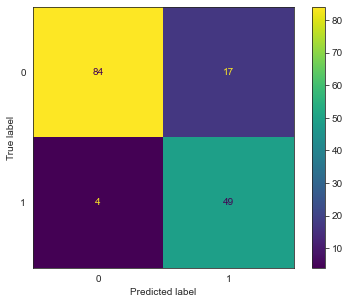

In [53]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=12)

# train test split
model.fit(X_train1, y_train1)
y_hat1 = model.predict(X_test1)

sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test1, y_pred=y_hat1, beta=2))
print(classification_report(y_test1, y_hat1))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, y_hat1)).plot()

### Of all 3 options tested above, best score results with this combination ->
### We choose this combination for our model


In [54]:
df_top_consolideted_results.reset_index().loc[0:3, ['index', 'Imbalance_f2']]

,index,Imbalance_f2
0,XGBClassifier,NeighbourhoodCleaningRule
1,RandomForestClassifier,NeighbourhoodCleaningRule
2,LGBMClassifier,NeighbourhoodCleaningRule
3,GradientBoostingClassifier,NeighbourhoodCleaningRule



### We attempted for a very aggresive model where we dont want to falsely dignose a diabetic patient as Non-diabetic 
> ### (can become risk to patients health if not treated for diabetes early)
### We have a nice recall for diabetic (1) classification

F2-SCORE: 0.8904109589041095
              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83       101
         1.0       0.65      0.98      0.78        53

    accuracy                           0.81       154
   macro avg       0.82      0.85      0.81       154
weighted avg       0.87      0.81      0.82       154



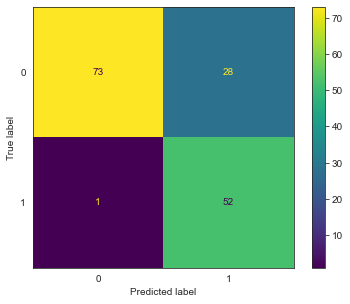

In [55]:
df_top_consolideted_results.reset_index().loc[0:4, ['index', 'Imbalance_f2']]

results = list()

# create pipeline
k = len(features_all)
fs = SelectKBest(score_func=f_classif, k=k)

step_RF = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['RandomForestClassifier'])]
step_gb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['GradientBoostingClassifier'])]
step_lgbm = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['LGBMClassifier'])]
step_xgb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['XGBClassifier'])]

pipe_RF = Pipeline_Imb(step_RF)
pipe_GB = Pipeline_Imb(step_gb)
pipe_LGB = Pipeline_Imb(step_lgbm)
pipe_XGB = Pipeline_Imb(step_xgb)

model = VotingClassifier(estimators=[
                                                ('rf', pipe_RF),
                                                ('lgbm', pipe_LGB),
                                                ('gb', pipe_GB),
                                                ('xgb', pipe_XGB)
                                                ],
                                                voting='soft'
                                                )

# train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=12)

# model build
model.fit(X_train1, y_train1)
y_hat1 = model.predict(X_test1)

# results
sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test1, y_pred=y_hat1, beta=2))
print(classification_report(y_test1, y_hat1))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, y_hat1)).plot()


### Lets see feature importances
### In here try to reduce features in model (avoid noise) while keeping same score

features:  ['f1' 'f10' 'f11' 'f12' 'f13' 'f14' 'f15' 'f2' 'f3' 'f4' 'f5' 'f6' 'f7'
 'f8' 'f9' 'Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness'
 'Insulin' 'BMI' 'DiabetesPedigreeFunction' 'Age']


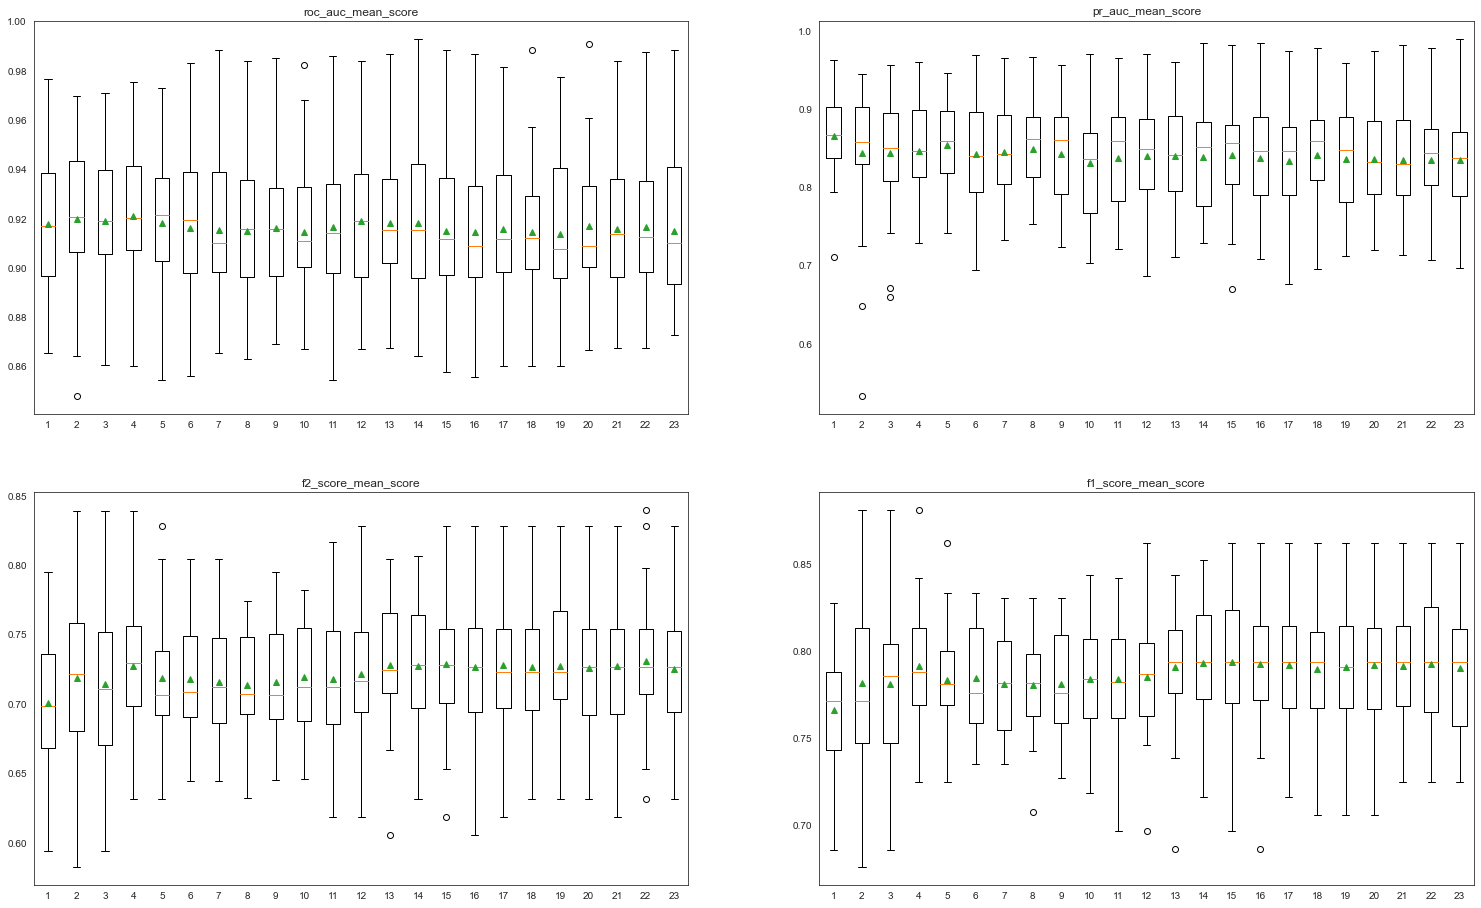

,roc_auc_mean_score,roc_auc_std_scores,pr_auc_mean_score,pr_auc_std_scores,f2_score_mean_score,f2_score_std_scores,f1_score_mean_score,f1_score_std_scores
0,0.917690,0.028144,0.865501,0.048528,0.700916,0.046865,0.766419,0.034647
1,0.919871,0.030570,0.843309,0.086199,0.718822,0.053860,0.781547,0.045104
2,0.919185,0.028771,0.844228,0.069801,0.714500,0.057037,0.781039,0.045422
3,0.921261,0.028118,0.846992,0.066034,0.727541,0.048884,0.791479,0.033732
4,0.918292,0.027758,0.854316,0.056279,0.718873,0.044172,0.783435,0.031924
5,0.916042,0.029613,0.842195,0.061481,0.718172,0.040464,0.784673,0.029988
6,0.915526,0.029089,0.844830,0.061575,0.715718,0.038018,0.781240,0.027622
7,0.914996,0.027527,0.848631,0.053463,0.713832,0.036669,0.780956,0.027982
8,0.916330,0.027067,0.842514,0.059887,0.715521,0.037612,0.781220,0.029416
9,0.914670,0.027000,0.830742,0.067831,0.719293,0.038823,0.784381,0.029050


In [56]:
# prepare data
X = data_imputed[features_all]
y = data_imputed.Outcome
print('features: ', X.columns.values)

# metrics
metrics = [('roc_auc', 'roc_auc'), ('pr_auc', custom_metrics.precision_recall_score), ('f2_score', custom_metrics.fO5_scorer), ('f1_score', custom_metrics.f1_score)]

# define number of features to evaluate
# enumerate each number of features
num_features = [i+1 for i in range(X.shape[1])]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
decimal, integer = math.modf(np.sqrt(len(metrics)))
entries = integer if decimal == 0 else (integer+1)

fig = plt.figure(figsize=(20, 12))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1 * entries)


df_results = pd.DataFrame()
for idx, metric in enumerate(metrics):
    results, result_mean, results_std = list(), list(), list()
    for k in num_features:
        fs = SelectKBest(score_func=f_classif, k=k)
        
        step_RF = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['RandomForestClassifier'])]
        step_gb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['GradientBoostingClassifier'])]
        step_lgbm = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['LGBMClassifier'])]
        step_xgb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['XGBClassifier'])]

        pipe_RF = Pipeline_Imb(step_RF)
        pipe_GB = Pipeline_Imb(step_gb)
        pipe_LGB = Pipeline_Imb(step_lgbm)
        pipe_XGB = Pipeline_Imb(step_xgb)

        model = VotingClassifier(estimators=[
                                                        ('rf', pipe_RF),
                                                        ('lgbm', pipe_LGB),
                                                        ('gb', pipe_GB),
                                                        ('xgb', pipe_XGB)
                                                        ],
                                                        voting='soft'
                                                        )
                
        # evaluate the model
        scores = custom_metrics.evaluate_model(model, X, y, metric[1])
        results.append(scores)
        result_mean.append(np.mean(scores))
        results_std.append(np.std(scores))

    ax = fig.add_subplot(entries, entries, idx + 1)
    ax.boxplot(results, labels=num_features, showmeans=True)
    ax.set_title(metric[0] + '_mean_score')
        
    df_results[metric[0] + '_mean_score'] = result_mean
    df_results[metric[0] + '_std_scores'] = results_std
    
plt.show()
df_results

### From above f1_score and f2_score are exceptionally high with the top 3 features with a good roc and pr scores
### We take top 3 features for modelling to reduce noise

Top 3 features :  ['Pregnancies' 'f8' 'f11']
brier score:  0.18291031373263292
F2-SCORE: 0.8732876712328768
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82       101
         1.0       0.64      0.96      0.77        53

    accuracy                           0.80       154
   macro avg       0.81      0.84      0.79       154
weighted avg       0.86      0.80      0.80       154



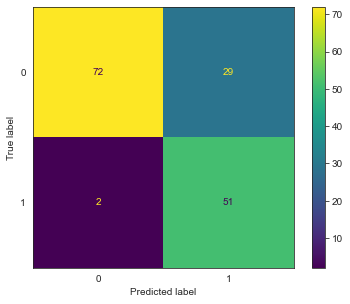

In [57]:
# prepare data
X = data_imputed[features_all]
y = data_imputed.Outcome

# select top features based on above metrics
k = 3

# metrics
fs = SelectKBest(score_func=f_classif, k=k)

fs.fit(X, y)
print('Top {} features : '.format(k), data_imputed.columns[fs.get_support(indices=True)].values)
        
step_RF = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['RandomForestClassifier'])]
step_gb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['GradientBoostingClassifier'])]
step_lgbm = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['LGBMClassifier'])]
step_xgb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['XGBClassifier'])]

pipe_RF = Pipeline_Imb(step_RF)
pipe_GB = Pipeline_Imb(step_gb)
pipe_LGB = Pipeline_Imb(step_lgbm)
pipe_XGB = Pipeline_Imb(step_xgb)

model = VotingClassifier(estimators=[
                                                ('rf', pipe_RF),
                                                ('lgbm', pipe_LGB),
                                                ('gb', pipe_GB),
                                                ('xgb', pipe_XGB)
                                                ],
                                                voting='soft'
                                                )
# train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=12)

# model build
model.fit(X_train1, y_train1)
y_hat1 = model.predict(X_test1)


# brier score
probs1 = model.predict_proba(X_test1)
probs1 = probs1[:, 1] # Keeping only the values in positive label
loss = brier_score_loss(y_test1, probs1)
print("brier score: ", loss)

# results
sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test1, y_pred=y_hat1, beta=2))
print(classification_report(y_test1, y_hat1))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, y_hat1)).plot()

### From this bier score of 18.46 %, we can infer that our model has a good performance or skill with just top 3 features selected while still keeping F2_score to 87% (near to 89%)
### Use PCA to remove noise and check whether we get same score as above
### Optimum components for max variability

In [74]:
# train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=12)

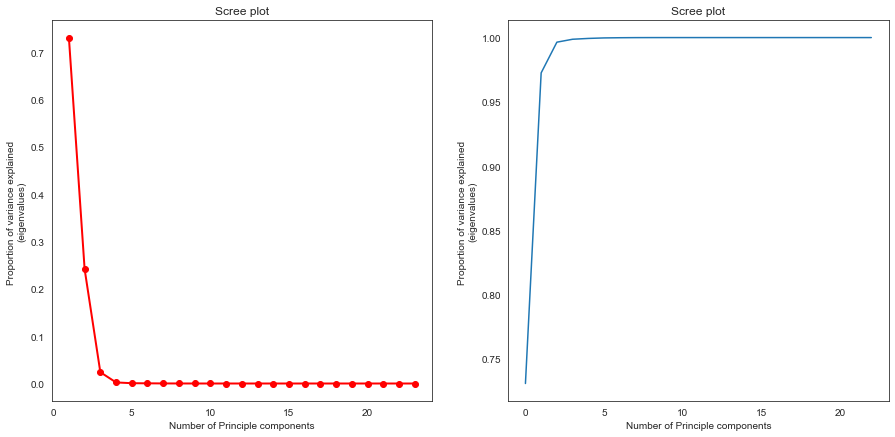

In [75]:
#scree plot to find those optimum components required to plot digits within reasonable acceptance range
sklearn_pca = PCA(n_components=X.shape[1]) # for 64 features there can be 64 PC's ...take all 64 PC's
sklearn_pca.fit(X_train1)
plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1,2,1)
PC_values = np.arange(sklearn_pca.n_components_) + 1
plt.plot(PC_values, sklearn_pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree plot')
plt.xlabel('Number of Principle components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.subplot(1,2,2)
plt.plot(np.cumsum(sklearn_pca.explained_variance_ratio_))
plt.title('Scree plot')
plt.xlabel('Number of Principle components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.show()

### First 5 components explain maximum variability amongst features. Use PCA on all features with components=5.

Top all features :  ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age' 'Outcome' 'f1' 'f2' 'f3' 'f4' 'f5' 'f6'
 'f7' 'f8' 'f9' 'f10' 'f11' 'f12' 'f13' 'f14']
brier score:  0.16594586890082313
F2-SCORE: 0.8620689655172414
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82       101
         1.0       0.64      0.94      0.76        53

    accuracy                           0.80       154
   macro avg       0.80      0.83      0.79       154
weighted avg       0.85      0.80      0.80       154



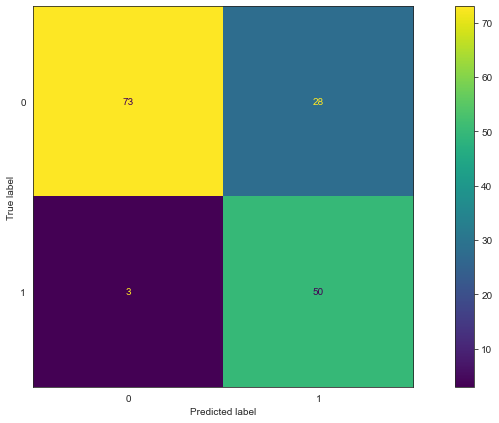

In [83]:
# prepare data
X = data_imputed[features_all]
y = data_imputed.Outcome

# select all features
k = 'all'

# metrics
fs = SelectKBest(score_func=f_classif, k=k)

fs.fit(X, y)
print('Top {} features : '.format(k), data_imputed.columns[fs.get_support(indices=True)].values)
        
step_RF = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['RandomForestClassifier'])]
step_gb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['GradientBoostingClassifier'])]
step_lgbm = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['LGBMClassifier'])]
step_xgb = steps_models_dict['NeighbourhoodCleaningRule'] + [('fs' ,fs)] + [('model', models_dict['XGBClassifier'])]

pipe_RF = Pipeline_Imb(step_RF)
pipe_GB = Pipeline_Imb(step_gb)
pipe_LGB = Pipeline_Imb(step_lgbm)
pipe_XGB = Pipeline_Imb(step_xgb)

model = VotingClassifier(estimators=[
                                                ('rf', pipe_RF),
                                                ('lgbm', pipe_LGB),
                                                ('gb', pipe_GB),
                                                ('xgb', pipe_XGB)
                                                ],
                                                voting='soft'
                                                )

# PCA treatment
pca = PCA(n_components=5)
pca.fit(X_train1)
x_train_transformed = pca.transform(X_train1)
x_test_transformed = pca.transform(X_test1)

# model build
model.fit(x_train_transformed, y_train1)
y_hat1 = model.predict(x_test_transformed)


# brier score
probs1 = model.predict_proba(x_test_transformed)
probs1 = probs1[:, 1] # Keeping only the values in positive label
loss = brier_score_loss(y_test1, probs1)
print("brier score: ", loss)

# results
sns.set_style('white')
print('F2-SCORE:', fbeta_score(y_true=y_test1, y_pred=y_hat1, beta=2))
print(classification_report(y_test1, y_hat1))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, y_hat1)).plot()

### Doing PCA we managed to->
* > ### 1. Removed noise from data by reducing dimentions in data (so less data eventually)
* > ### 2. Improve on loss brier score from 18.29 % to 16.59 % thereby imporving probabilistic performance of our model
* > ### 3. Keep F2 score (86.20%) very close to 87.32 % (without PCA)
* > ### 4. Very nice recall on Diabetic (just 3 false negative for diabetic)